<h1 align='center'><font color="#1a2457"> Аналитика в Яндекс.Афише </font></h1>

Внимание! Это учебный проект, в проекте не доступен перезапуск ячеек. Датасеты Яндекса защищены соглашением о неразглашении.

## Описание проекта

Общее задание: дать рекомендации маркетологам о том как оптимизировать расходы на рекламу

В распоряжении были данные от Яндекс.Афиши за 2017-2018 года (промежуток в 1 год), это 3 таблицы: visits с информацией о посещениях сайта, orders с информацией о заказах и costs с информацией о затратах на маркетинг

Проект отвечает на вопросы: как посетители сайта пользуются им, как быстро начинают покупать, сколько тратит каждый клиент, когда клиент окупается.



<h2 align='center'><font color="#513614"> Шаг 1. Загрузка и подготовка данных </font></h2><br>

Импортируем библиотеки для работы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
import seaborn as sns
import datetime as dt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.options.mode.chained_assignment = None

In [2]:
#здесь мы загружаем датасеты из csv в pandas, но т.к. они защищены соглашением о неразглашении, перезапуск этого процесса не доступен

#visits_log = pd.read_csv('visits_log.csv')
#orders_log = pd.read_csv('orders_log.csv')
#costs_log = pd.read_csv('costs.csv')

---

Рассмотрим первый датасет, предположительно, с везитами на сайт Яндекс.Афиши - visits_log

In [3]:
visits_log.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

Нужно привести названия столбцов к нижнему регистру и добавить "_" там где это необходимо

In [4]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Перевести столбцы End Ts и Start Ts к типу данных datetime

In [5]:
visits_log.describe()

Source Id           Uid
count  359400.000000  3.594000e+05
mean        3.750515  9.202557e+18
std         1.917116  5.298433e+18
min         1.000000  1.186350e+13
25%         3.000000  4.613407e+18
50%         4.000000  9.227413e+18
75%         5.000000  1.372824e+19
max        10.000000  1.844668e+19

Судя по Source Id всего источников 10, и большая часть трафика распределена между 3,4 и 5 источниками. Далее нужно будет изучить это подробнее

In [6]:
visits_log.duplicated().value_counts()

False    359400
dtype: int64

Дубликатов нет

<b>Внимание, сообщение из будущего</b>: при проверке длительности сессий в этой таблице было обнаружено, что длительности округлены до 1 минуты, и многие из них в меньшую сторону (т.е. 0 минут), но в самом конце датасета обнаружены 19-секундные сессии. Осмелюсь предположить, что 19-секундные сессии образовлись в момент снятия статистики, т.е. это как бы прерванные сессии людей (срез в момент выгрузки) или иная ошибка. 

Я думаю можно округлить эти строки, причём в большую сторону, т.к. вероятность, что они пробыли на сайте больше 19 велика. В любом случае этих строк менее 1% от всех строк поэтому их изменение не повредит выводам.

---

In [7]:
orders_log.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

Здесь так же нужно привести названия столбцов к нижнему регистру и добавить "_" там где это необходимо

In [8]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Перевести столбец Buy Ts к типу данных datetime

In [9]:
orders_log.describe()

Revenue           Uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19

Есть большие выбросы в столбце Revenue, учитывая, что 75% трафика до 4,89, а максимальый доход с одного заказа 2633,28 (долларов?)

In [10]:
orders_log.duplicated().value_counts()

False    50415
dtype: int64

Дубликатов нет

---

In [11]:
costs_log.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In [12]:
costs_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Нужно поменять тип данных столбца dt

In [13]:
costs_log.describe()

source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581   156.296628
min       1.000000     0.540000
25%       2.000000    21.945000
50%       4.000000    77.295000
75%       9.000000   170.065000
max      10.000000  1788.280000

Максимальное значение costs сильно выделяется на фоне 75% меньших значений, скорее всего тут тоже выбросы

In [14]:
costs_log.duplicated().value_counts()

False    2542
dtype: int64

Дубликатов нет

---

###### Переименуем столбцы

Т.к. столбцы содержат не только верхний регистр, но и пробелы, я решил, что быстрее будет просто вручную переименовать их и не тратить время на нагромаждения вокруг простой задачи.

In [15]:
visits_log.columns = ['device','end_ts','source_id','start_ts','uid']
visits_log.head()

device               end_ts  source_id             start_ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [16]:
orders_log.columns = ['buy_ts','revenue','uid']
orders_log.head()

buy_ts  revenue                   uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

###### Поменяем типы данных

In [17]:
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [18]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [19]:
costs_log['dt'] = pd.to_datetime(costs_log['dt'])
costs_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


---

###### Округлим даты

Теперь округлим последние строки датасета, где кончание сессии (столбец end_ts) не округлено и оканчивается на 19 секунд

In [20]:
visits_log['end_ts'] = visits_log['end_ts'].dt.ceil('1T')
visits_log

device              end_ts  source_id            start_ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:08:00          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:39:00          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:13:00          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:13:00          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:14:00          2 2017-09-10 13:13:00   

                         uid  
0       16879256277535980062  
1         104060357244891740  
2        7459035603376831527  
3       16174680259334210214  
4        9969694820036681168  
...                      ...  
359395  18363291481961487539  
359396  18370831553019119586  
359397  18387297585500748294  
359398  18388616944624776485  
359399  18396128934054549559  

[359400 rows x 5 columns]

Вывод: В целом данные достаточно полноценные для анализа, преобразований пришлось делать не много, теперь можно анализировать

---

<h2 align='center'><font color="#513614"> Шаг 2. Построение отчётов и подсчёт метрик </font></h2>

В данном шаге ответы на ключевые вопросы от команды маркетологов

---

<h3 align='center'><font color="#173b3f"> Сколько людей пользуются в день, неделю, месяц? </font></h3><br>

Для расчёта нужно выделить день, неделю и месяц посещения, затем создать сгруппированные датасеты с уникальными пользователями по этим промежуткам времени:

In [21]:
visits_log['day'] = visits_log['start_ts'].astype('datetime64[D]')
visits_log['week'] = visits_log['start_ts'].astype('datetime64[W]')
visits_log['month'] = visits_log['start_ts'].astype('datetime64[M]')

visits_log_daily = visits_log.groupby(['day']).agg({'uid':'nunique'})
visits_log_weekly = visits_log.groupby(['week']).agg({'uid':'nunique'})
visits_log_monthly = visits_log.groupby(['month']).agg({'uid':'nunique'})
print(
    "В среднем в день сайт посещают:",
    round(visits_log_daily['uid'].mean()),
    "человек (DAU)\nВ среднем в неделю сайт посещают:",
    round(visits_log_weekly['uid'].mean()),
    "человек (WAU)\nВ среднем в месяц сайт посещают:",
    round(visits_log_monthly['uid'].mean()),
    "человек (MAU)"
)

В среднем в день сайт посещают: 908 человек (DAU)
В среднем в неделю сайт посещают: 5724 человек (WAU)
В среднем в месяц сайт посещают: 23228 человек (MAU)


Посмотрим какой разброс посещаемости в рамках дня, недели, месяца

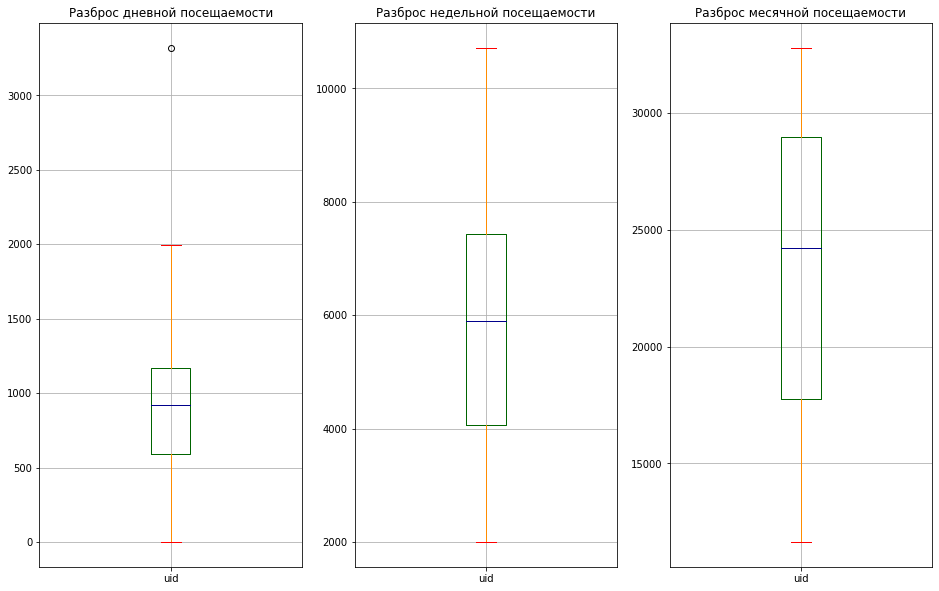

In [22]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Red'}
fig, axes = plt.subplots(1, 3, figsize=(16, 10))
visits_log_daily['uid'].plot.box(title='Разброс дневной посещаемости', grid=True, ax=axes[0], color=color)
visits_log_weekly['uid'].plot.box(title='Разброс недельной посещаемости', grid=True, ax=axes[1], color=color)
visits_log_monthly['uid'].plot.box(title='Разброс месячной посещаемости', grid=True, ax=axes[2], color=color)

plt.show()

И ещё интересно как посещаемость сайта изменяется на протяжении всего времени, по дням

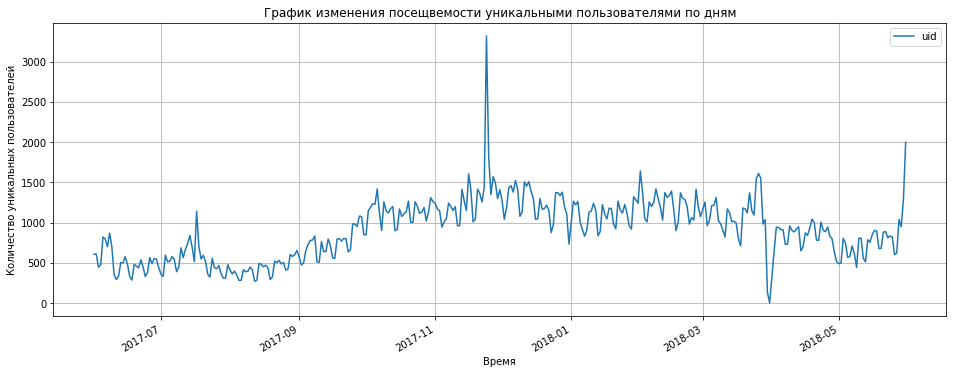

In [23]:
visits_log_daily.plot.line(title="График изменения посещвемости уникальными пользователями по дням",  grid=True, figsize=(16, 6))
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Время')
plt.show()

Видно, что посещаемость с наступлением осени 2017 начала растри, и даже был необычный пик:

In [24]:
visits_log_daily[visits_log_daily.index=='2017-11-24']

uid
day             
2017-11-24  3319

24 ноября 2017 - много людей, много раз посещали сайт, видимо там было какое-то яркое событие, которое широко рекламировалось. 

Я воспользовался сервисом https://web.archive.org и выяснил, что там была <b> черная пятница </b> и видимо распродажа билетов на Ozzy Osborn'a в Олимпийском или Guns'n'Roses в Крокус Сити Холл.

А весной посещаемость начала падать, видимо это сезонный процесс, зимой больше людей интересуются концертами и выступлениями, а летом отдыхают на даче и на море. Есть ещё один необычный день, 31 марта 2018:

In [25]:
visits_log_daily[visits_log_daily.index=='2018-03-31']

uid
day            
2018-03-31    1

Почему-то в этот сайт посетил всего один человек, это точно ошибка, возможно сайт был на реконструкции в этот день. Так же есть взлет посещаемости к 31 мая 2018:

In [26]:
visits_log_daily[visits_log_daily.index>='2018-05-29']

uid
day             
2018-05-29   948
2018-05-30  1289
2018-05-31  1997

Возможно там тоже было широко рекламируемое событие, премьера. В этот день празднуется "Всемирный день без табака" и "Всемирный день блондинок", но не думаю, что этот всплеск как-то связан с этим

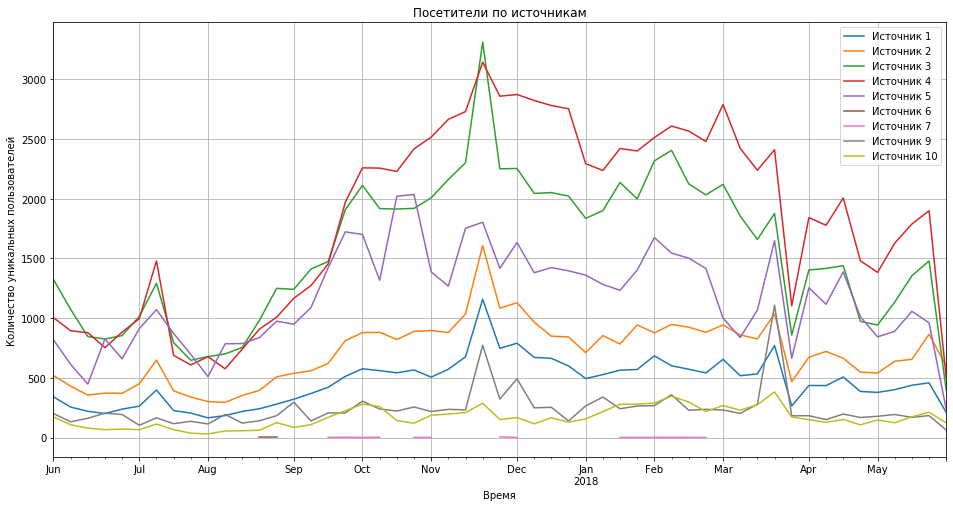

In [27]:
(visits_log
    .pivot_table(index='week', columns='source_id', values='uid', aggfunc='nunique')
    .plot(title='Посетители по источникам', grid=True)
    )
plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 6','Источник 7','Источник 9','Источник 10'])
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Время')
plt.show()

С источников 3 и 4 приходит больше новых (уникальных) пользователей и на протяжении всего времени трафик уникальных пользователей по ним преобладает, особенно в холодные месяцы года.

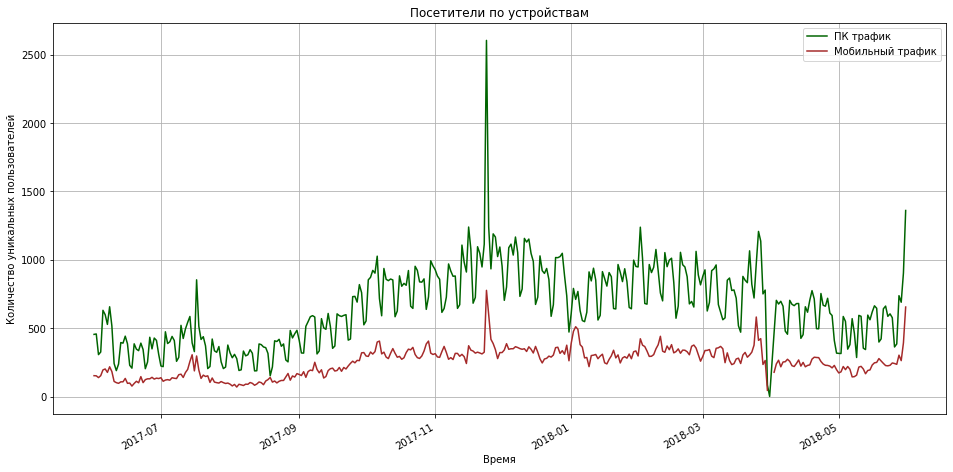

In [28]:
(visits_log
    .pivot_table(index='day', columns='device', values='uid', aggfunc='nunique')
    .plot(title='Посетители по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Время')
plt.show()

Преобладает ПК, оттуда приходит больше уникальных пользователей. На графике видно, сильная разность трафика внтури недели по desktop-у, в будни люди заходят на работе в минуты отдыха, а на выходных только из дома. С touch-устройств трафик более стабильный. 

В холодные месяцы пользователей с ПК становится больше (все вернулись с отпусков на работу). Опять же виден всплеск в черную пятницу.

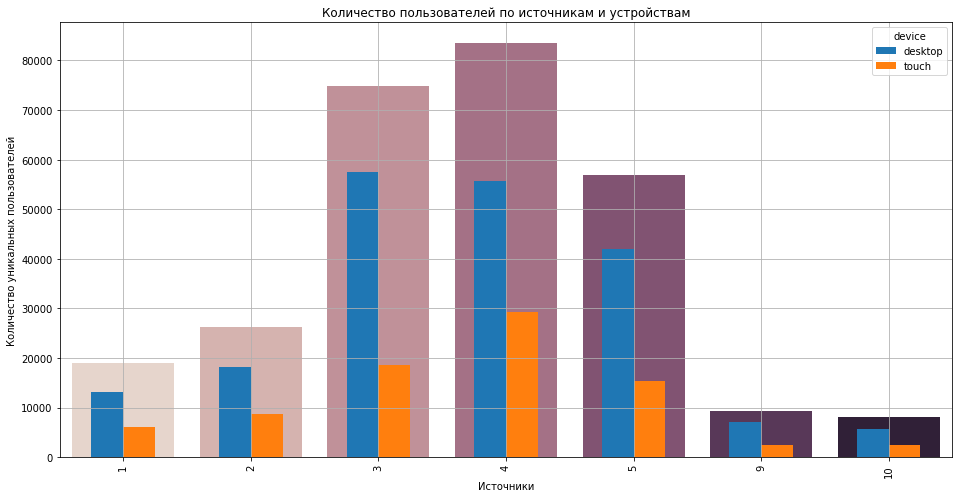

In [29]:
source_df = (visits_log
             .query('(source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'uid':'nunique'})
             .reset_index()
            )

source_and_device_df = (visits_log
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'uid':'nunique'})
                        .reset_index()
                        .pivot_table(index='source_id', columns='device', values='uid', aggfunc='sum')
                       )

ax = sns.barplot(x='source_id', y='uid', palette="ch:.1", data=source_df)
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)

plt.title('Количество пользователей по источникам и устройствам')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Источники')
plt.show()

##### В этом и на последующих подобных графиках: на переднем плане сравнение desktop и touch-трафика (т.е. ПК и мобильного), а на заднем плане — тот же показатель, без разбиения на устройства. 

##### Там где суммарное количество едениц - задний столбец будет суммой desktop+touch, а там где среднее число - средним между desktop и touch

Здесь мы явно видим какие каналы привлекают больше уникальных пользователей, и на сколько по каждому каналу ПК-трафик преобладает над мобильным. Особая разница по 3-му источнику.

---

<h3 align='center'><font color="#173b3f"> Сколько сессий в день? </font></h3><br>

In [30]:
print(f'В среднем {round(visits_log.groupby("day")["start_ts"].count().mean())} сессий в день')

print(f'В среднем {round(visits_log.groupby(["day", "uid"])["start_ts"].count().mean(), 2)} сессий на одного пользователя')

В среднем 987 сессий в день
В среднем 1.09 сессий на одного пользователя


---

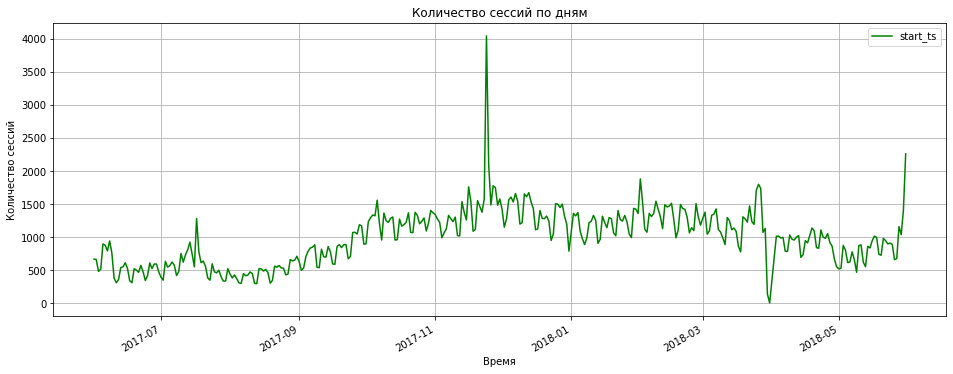

In [31]:
(visits_log
     .groupby("day")[["start_ts"]]
     .count()
     .plot.line(title='Количество сессий по дням', grid=True, figsize=(16, 6), color='green')
)
plt.ylabel('Количество сессий')
plt.xlabel('Время')
plt.show()

Видно всё те же самые пики, что и в статистике по уникальным пользователям, но интересно ещё узнать сколько сессий приходится на одного пользователя и как изменяется этот показатель с течением времени:

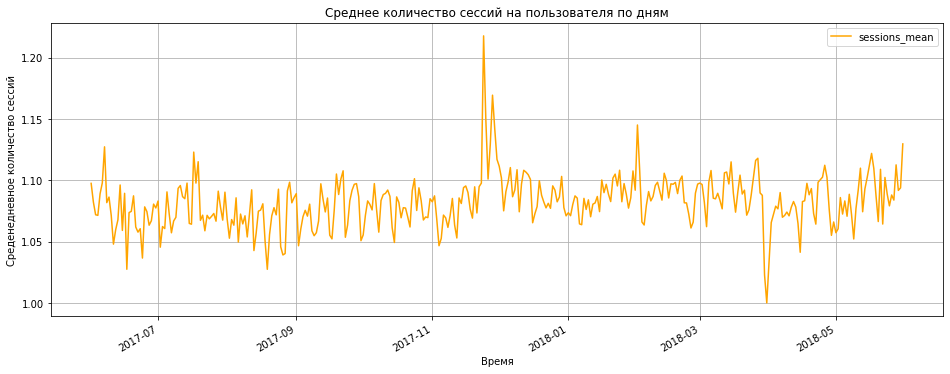

In [32]:
sessions_count = visits_log.groupby(["day", "uid"])[["start_ts"]].count().reset_index()
sessions_means = sessions_count.groupby("day")[["start_ts"]].mean()
sessions_means = sessions_means.rename(columns = {'start_ts':'sessions_mean'})

sessions_means.plot.line(title='Среднее количество сессий на пользователя по дням', grid=True, figsize=(16, 6), color='orange')

plt.ylabel('Среденедневное количество сессий')
plt.xlabel('Время')
plt.show()

В целом за год среднее количество сессий на одного пользователя колеблется между 1.05 и 1.10 (т.е. можно предположить, что каждый 10 пользователь посещает сайт 2 раза в день), но есть тот самый пик в черную пятницу, в котором пользователи особо активно обновляли страницы сайта, и посещали по несколько раз в день. Т.е. если раньше можно было предположить, что это разные пользователи пришли на сайт одновременно, то сейчас можно утверждать, что это одни и те же люди посещали сайт в поисках скидок.

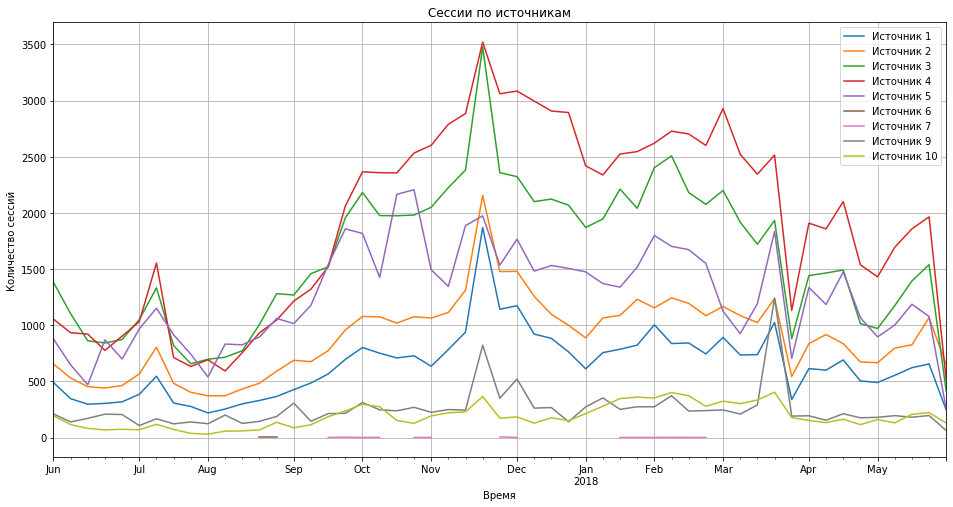

In [33]:
(visits_log
    .groupby(['source_id','week'])['start_ts']
    .count()
    .reset_index()
    .pivot_table(index='week', columns='source_id', values='start_ts', aggfunc='sum')
    .plot(title='Сессии по источникам', grid=True)
)
plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 6','Источник 7','Источник 9','Источник 10'])
plt.ylabel('Количество сессий')
plt.xlabel('Время')
plt.show()

Сессии повторяют картину по уникальных пользователям. С небольшой разницей по 1 и 2 источнику, с них чаще возвращаются.

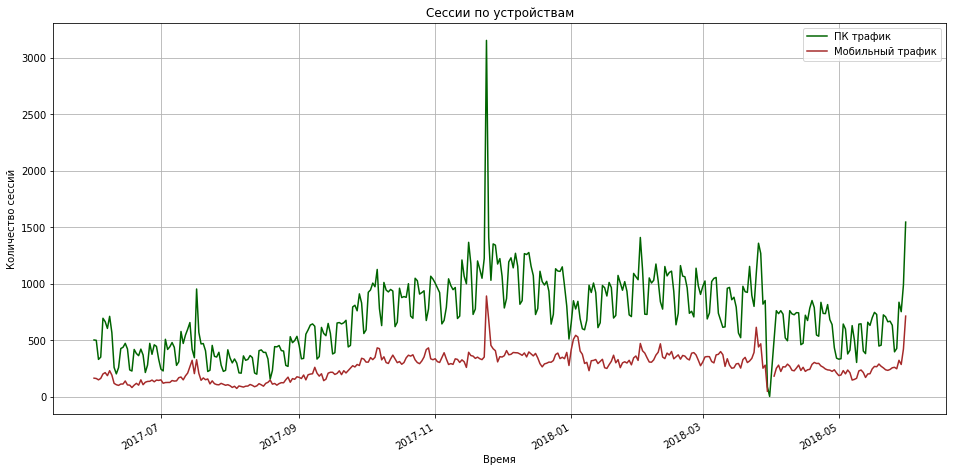

In [34]:
(visits_log
    .groupby(['device','day'])['start_ts']
    .count()
    .reset_index()
    .pivot_table(index='day', columns='device', values='start_ts', aggfunc='sum')
    .plot(title='Сессии по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Количество сессий')
plt.xlabel('Время')
plt.show()

Видно, что пик в чёрную пятницу выше, люди активно возвращались и обновляли сайт

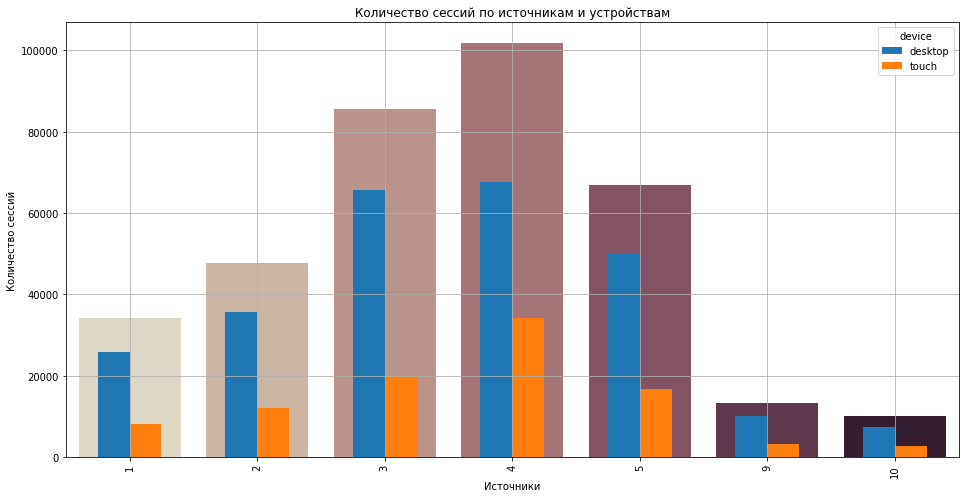

In [35]:
source_df = (visits_log
             .query('(source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'start_ts':'count'})
             .reset_index()
            )

source_and_device_df = (visits_log
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'start_ts':'count'})
                        .reset_index()
                        .pivot_table(index='source_id', columns='device', values='start_ts', aggfunc='sum')
                       )

ax = sns.barplot(x='source_id', y='start_ts',  palette="ch:.3", data=source_df)
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)

plt.title('Количество сессий по источникам и устройствам')
plt.ylabel('Количество сессий')
plt.xlabel('Источники')
plt.show()

В сравнении с трафиком уникальных пользователей, здесь подросли показатели по 1 и 2 источнику, как я и писал выше, по этим источникам возвращаются чаще, и возможно даже те, кто изначально пришёл по другому источнику. Так же возросла разница между ПК и мобильными, видимо удобнее смотреть сайт с ПК и люди переходят.

---

<h3 align='center'><font color="#173b3f"> Сколько длится одна сессия? </font></h3><br>

Забегая вперед, обнаружил строки, в которых люди вышли с сайта раньше, чем зашли :) Возможно у них сменился часовой пояс, например они вошли на сайт в одном городе, а вышли уже в другом (где часовой пояс -1 час):

In [36]:
visits_log[visits_log['end_ts'] < visits_log['start_ts']]

device              end_ts  source_id            start_ts  \
4181    desktop 2018-03-25 03:18:00          3 2018-03-25 03:50:00   
177972  desktop 2018-03-25 03:09:00          9 2018-03-25 03:55:00   

                         uid        day       week      month  
4181    13092152539246794986 2018-03-25 2018-03-22 2018-03-01  
177972   4621202742905035453 2018-03-25 2018-03-22 2018-03-01

Удалим их, чтоб не вызывали аномалии в статистике

In [37]:
visits_log = visits_log.drop(index=[4181, 177972])
visits_log[visits_log['end_ts'] < visits_log['start_ts']]

Empty DataFrame
Columns: [device, end_ts, source_id, start_ts, uid, day, week, month]
Index: []

---

Создадим столбец с длительностью

In [38]:
visits_log['duration_ts'] = (visits_log['end_ts'] - visits_log['start_ts'])/ np.timedelta64(1,'s')
visits_log['duration_ts']

0         1080.0
1         1680.0
2            0.0
3         1440.0
4            0.0
           ...  
359395      60.0
359396      60.0
359397      60.0
359398      60.0
359399      60.0
Name: duration_ts, Length: 359398, dtype: float64

Подозрительные данные, в первых строках - видно, что сессии округлены до минут, и некоторые в меньшую сторону, поэтому равны 0

In [39]:
zero_duration_uids = visits_log[visits_log['duration_ts'] == 0]['uid']

orders_log.query('(uid in @zero_duration_uids) and (revenue > 0)')['uid'].count()

10985

При том, что у людей нулевые сессии, 10985 из них совершали покупки... вот почему не стоит просто брать и удалять нулевые сессии

---

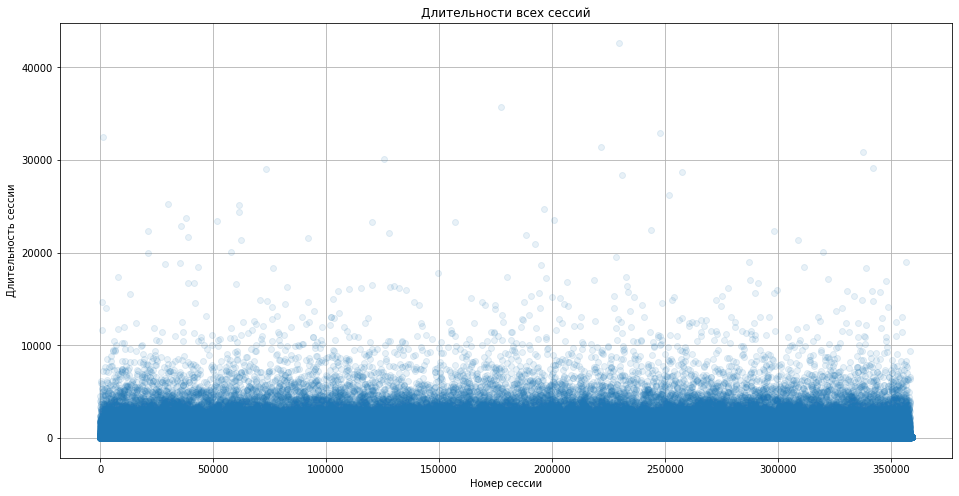

In [40]:
visits_log['duration_ts'].plot(title='Длительности всех сессий', grid=True, figsize=(16, 8), style='o', alpha=0.1)
plt.ylabel('Длительность сессии')
plt.xlabel('Номер сессии')
plt.show()

In [41]:
visits_log['duration_ts'].describe()

count    359398.000000
mean        643.141309
std         997.045268
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: duration_ts, dtype: float64

Средняя продолжительность сессии 10 минут 43 секунды, однако медиана прошла в 5 минутах, т.е. выбросы некоторых сессий отклонили среднюю больше чем в 2 раза от медианы. Что будет если удалить выбросы, например ограничимся 30 минутами? (1800 секунд, такое значение взято т.к. это стандарт в Яндекс.Метрике)

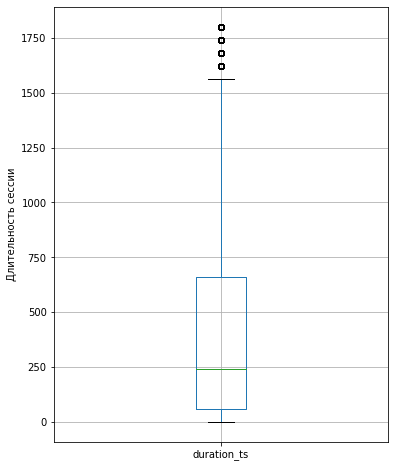

In [42]:
true_visits_log = visits_log[visits_log['duration_ts'] <= 1800]['duration_ts']
true_visits_log.plot.box(grid=True, figsize=(6, 8))
plt.ylabel('Длительность сессии')
plt.show()

In [43]:
true_visits_log.describe()

count    331507.000000
mean        431.280305
std         457.164472
min           0.000000
25%          60.000000
50%         240.000000
75%         660.000000
max        1800.000000
Name: duration_ts, dtype: float64

Вот теперь медиана осталась на прежнем уровне, а средняя уменьшилась сразу на 3,5 минуты (10:43 -> 7:11), при этом количество записей сократилось всего на 7,8%

##### Итак, предлагаю считать 7 минут 11 секунд средней длительностью большинства посещений

Посмотрим как менялась продолжительность сессии в течение года

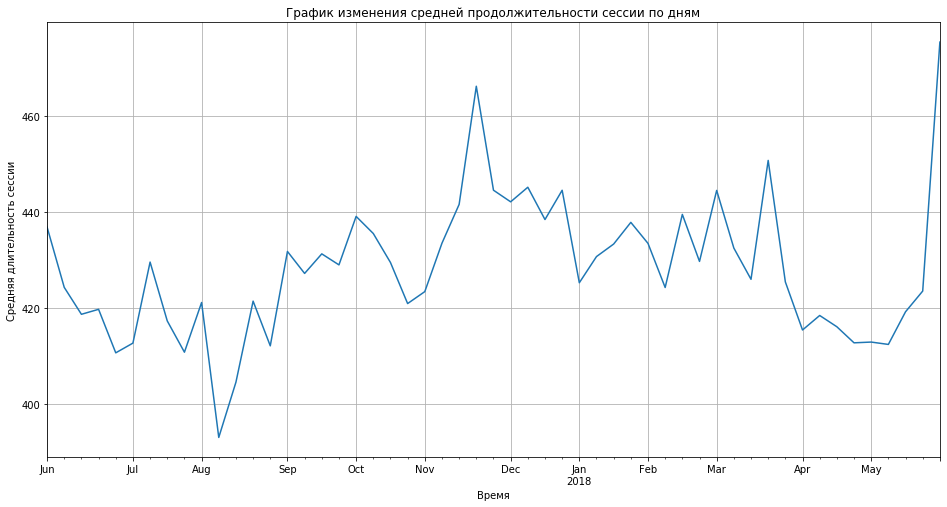

In [44]:
(visits_log
    .query('duration_ts in @true_visits_log')
    .groupby('week')['duration_ts']
    .mean()
    .plot.line(title="График изменения средней продолжительности сессии по дням",  grid=True, figsize=(16, 8))
)
plt.ylabel('Средняя длительность сессии')
plt.xlabel('Время')
plt.show()

В целом на протяжении года продолжительность сессии не сильно менялась, от 430 +/- 30 секунд. Летом меньше, зимой больше.

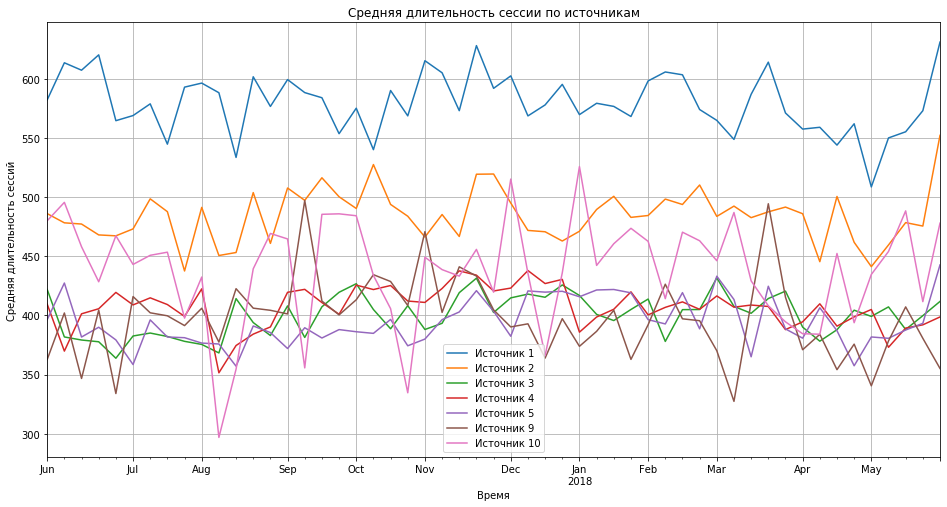

In [45]:
(visits_log
    .query('(duration_ts in @true_visits_log) and (source_id != 6) and (source_id != 7)') # у 6,7 источника мало данных, график не отражает реальность
    .groupby(['source_id','week'])['duration_ts']
    .mean()
    .reset_index()
    .pivot_table(index='week', columns='source_id', values='duration_ts', aggfunc='mean')
    .plot(title='Средняя длительность сессии по источникам', grid=True)
)

plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Средняя длительность сессий')
plt.xlabel('Время')
plt.show()

Лидерами по продолжительности сессии стали 1 и 2 источники, видимо по ним приходят ещё не знакомые с сайтом, поэтому они долго изучают и выбирают. Так же можно предположить, что это и более лояльные люди, готовые покупать.

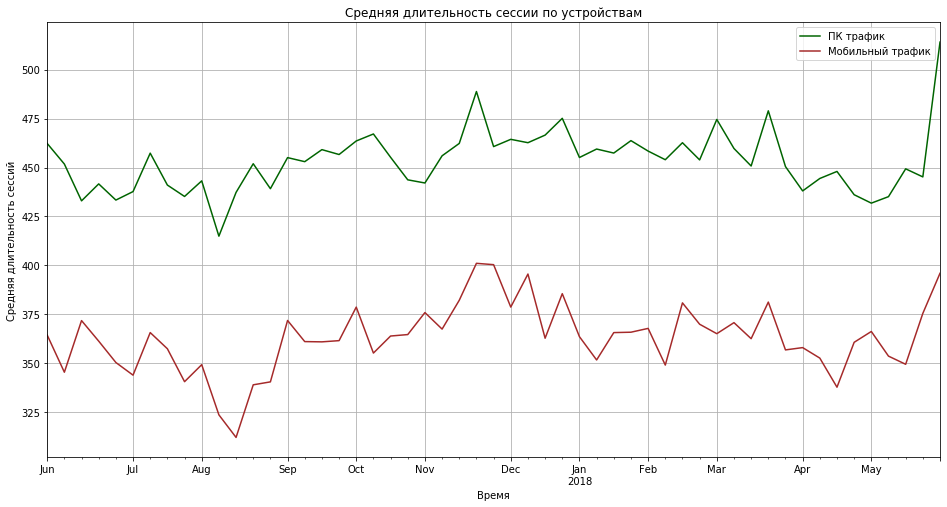

In [46]:
(visits_log
    .query('duration_ts in @true_visits_log')
    .groupby(['device','week'])['duration_ts']
    .mean()
    .reset_index()
    .pivot_table(index='week', columns='device', values='duration_ts', aggfunc='mean')
    .plot(title='Средняя длительность сессии по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Средняя длительность сессий')
plt.xlabel('Время')
plt.show()

Трафик с мобильных значительно быстрее уходит сайта: либо сайт на мобильном даёт нужную информацию доступнее и быстрее, либо наоборот, изучать сайт в таком виде не удобно и люди переходят в ПК. Я склоняюсь ко второму.

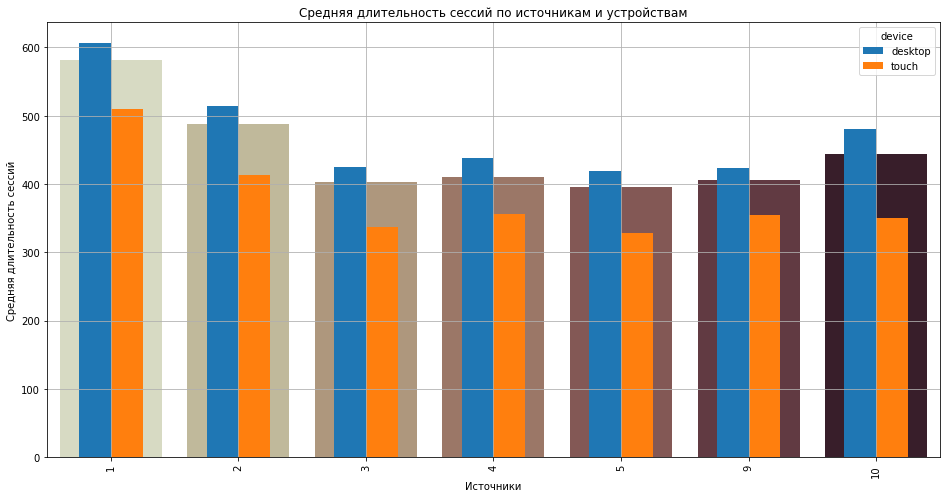

In [47]:
source_df = (visits_log
             .query('(duration_ts in @true_visits_log) and (source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'duration_ts':'mean'})
             .reset_index()
            )

source_and_device_df = (visits_log
                        .query('(duration_ts in @true_visits_log) and (source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'duration_ts':'mean'})
                        .reset_index()
                        .pivot_table(index='source_id', columns='device', values='duration_ts', aggfunc='mean')
                       )

ax = sns.barplot(x='source_id', y='duration_ts',  palette="ch:.5", data=source_df)
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)

plt.title('Средняя длительность сессий по источникам и устройствам')
plt.ylabel('Средняя длительность сессий')
plt.xlabel('Источники')
plt.show()

1 источник даёт самый усидчевый трафик, а в целом средняя продолжительность сессии везде одинакова, и относительная разница ПК с мобильным трафиком так же везде одинакова.

---

<h3 align='center'><font color="#173b3f"> Как часто люди возвращаются? </font></h3><br>

Создадим таблицу с первыми посещениями пользователей и соединим с основной

In [48]:
first_activity_date = visits_log.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_session'
visits_log = visits_log.join(first_activity_date,on='uid')
visits_log['first_session_month'] = visits_log['first_session'].astype('datetime64[M]')
visits_log.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid        day       week      month  duration_ts  \
0  16879256277535980062 2017-12-20 2017-12-14 2017-12-01       1080.0   
1    104060357244891740 2018-02-19 2018-02-15 2018-02-01       1680.0   
2   7459035603376831527 2017-07-01 2017-06-29 2017-07-01          0.0   
3  16174680259334210214 2018-05-20 2018-05-17 2018-05-01       1440.0   
4   9969694820036681168 2017-12-27 2017-12-21 2017-12-01          0.0   

        first_session first_session_month  
0 2017-12-20 17:20:00          2017-12-01  
1 2018-02-19 16:53:00          2018-02-01  
2 2017-07-01 01:54:00          2017-07-01  
3 2018-03-09 20:05:00          2018-03-01  
4 2017-12-27 14:06:00          2017-12-01

Сгруппируем таблицу для создания когорт

In [49]:
visits_by_cohorts = visits_log.groupby(['first_session_month','month']).agg({'start_ts':'count','uid':'nunique'}).reset_index()
visits_by_cohorts = visits_by_cohorts.rename(columns = {'start_ts':'count_of_sessions', 'uid':'unique_users'})
visits_by_cohorts.head()

first_session_month      month  count_of_sessions  unique_users
0          2017-06-01 2017-06-01              16505         13259
1          2017-06-01 2017-07-01               2412          1043
2          2017-06-01 2017-08-01               1758           713
3          2017-06-01 2017-09-01               2260           814
4          2017-06-01 2017-10-01               2679           909

In [50]:
visits_by_cohorts['cohort_month'] = (( visits_by_cohorts['month'] - visits_by_cohorts['first_session_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
visits_by_cohorts['first_session_month'] = visits_by_cohorts['first_session_month'].dt.strftime('%Y-%m')

Сделаем временную таблицу с количеством уникальных пользователей когорт

In [51]:
initial_users = visits_by_cohorts[visits_by_cohorts['cohort_month'] == 0][['first_session_month','unique_users']]
initial_users = initial_users.rename(columns = {'unique_users':'cohort_users'})
initial_users

first_session_month  cohort_users
0              2017-06         13259
12             2017-07         13140
23             2017-08         10181
33             2017-09         16704
42             2017-10         25977
50             2017-11         27248
57             2017-12         25268
63             2018-01         22624
68             2018-02         22197
72             2018-03         20589
75             2018-04         15709
77             2018-05         15273

In [52]:
visits_by_cohorts = visits_by_cohorts.merge(initial_users, on='first_session_month')

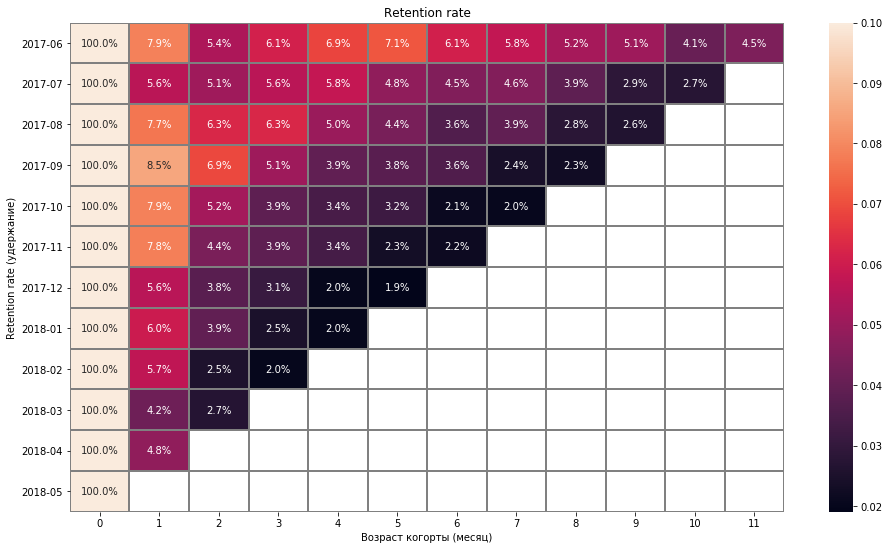

In [53]:
visits_by_cohorts['retention'] = visits_by_cohorts['unique_users']/visits_by_cohorts['cohort_users'] # столбец с процентом возврата пользователей
retention_pivot = visits_by_cohorts.pivot_table(index='first_session_month',columns='cohort_month',values='retention',aggfunc='sum') # pivot для построения тепловой карты когорт
plt.figure(figsize=(16, 9))
plt.title('Retention rate')
sns.heatmap(retention_pivot, vmax=0.1, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

plt.ylabel('Retention rate (удержание)')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

Видно как хорошо возвращаются люди из первой когорты, и не очень хорошо возвращаются люди из последующих когорт. Но нужно понимать, что в первую когорту входят все те, кто ещё раньше (за пределами статистики) стали постоянными посетителями. Т.е. если бы мы взяли когорты за прошлые года, то когорта 2017-06 выглядела бы совершенно иначе и была больше похожа на все последующие (2017-07, 2017-08 и т.д.)

А вот когорту 2017-09 действительно можно рассматривать как особо успешную, там в следующем месяце вернулось 8,5% людей против 5-6% в других когортах. И в следующем месяце тоже лучший показатель возврата. Стоит посмотреть, что было сделано для того, чтобы вернуть людей в те месяцы и ввести данные меры в регулярную деятельность

---

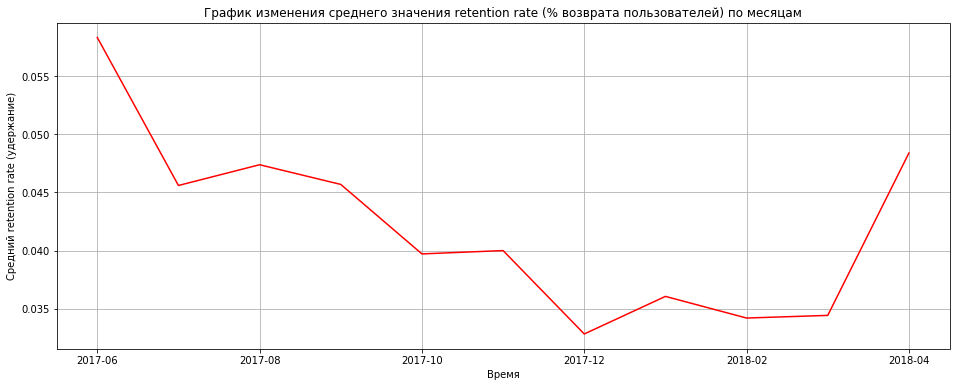

In [54]:
(visits_by_cohorts[visits_by_cohorts['cohort_month'] > 0]
    .groupby('first_session_month')['retention']
    .mean()
    .plot.line(title='График изменения среднего значения retention rate (% возврата пользователей) по месяцам', color='red', grid=True, figsize=(16,6))
)

plt.ylabel('Средний retention rate (удержание)')
plt.xlabel('Время')
plt.show()

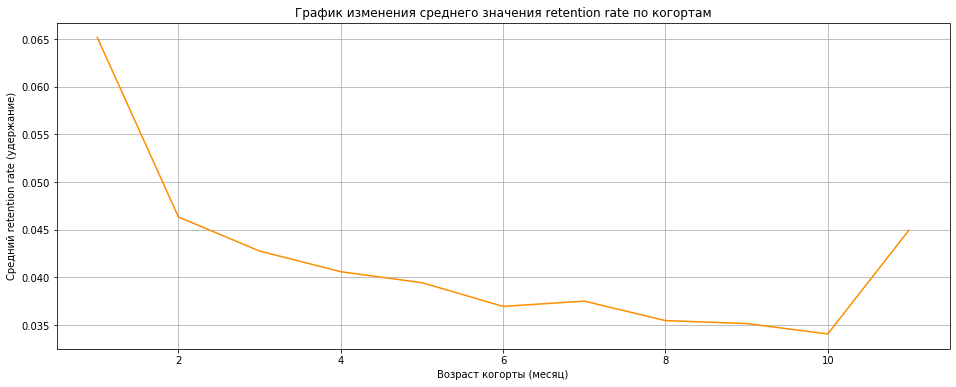

In [55]:
(visits_by_cohorts[visits_by_cohorts['cohort_month'] > 0]
    .groupby('cohort_month')['retention']
    .mean()
    .plot.line(title='График изменения среднего значения retention rate по когортам', color='darkorange', grid=True, figsize=(16,6))
)

plt.ylabel('Средний retention rate (удержание)')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

Видно, что и с течением времени когорта меньше посещает сайт (в среднем), и у новых когорт падает процент возврата. Получается новым пользователям сайт кажется не таким полезным, чтобы на него возвращаться, я бы предложил создать новостную рассылку и с умеренной агресивностью предлагать подписаться новым пользователям, напремер еженедельник о новых мероприятиях, а письма ссылались бы на сайт, тем самым возвращали людей обратно, за покупками.

<b> Churn Rate </b>

Chern Rate – это процент посетителей, которые отказались от повторного посещения сайта на следующий период (месяц, например) или вернувшиеся, если процент положительный, т.е. их стало больше, чем в прошлом периоде.

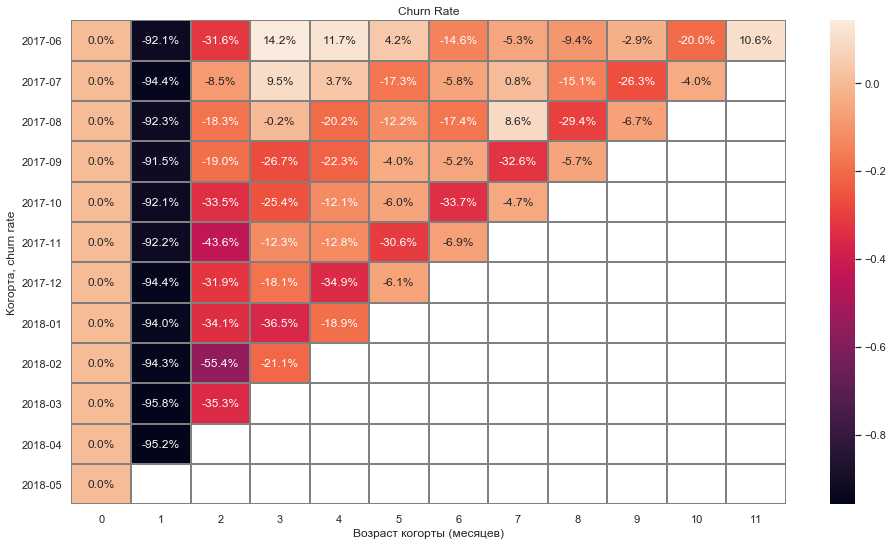

In [56]:
visits_by_cohorts['churn_rate'] = visits_by_cohorts.groupby(['first_session_month'])['unique_users'].pct_change() #процент изменения по отношению к предыдущему периоду

churn_pivot = visits_by_cohorts.pivot_table(index='first_session_month',columns='cohort_month',values='churn_rate',aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(16, 8.9))
sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

plt.title('Churn Rate')
plt.ylabel('Когорта, churn rate')
plt.xlabel('Возраст когорты (месяцев)')
plt.show()

Видно, что возвращаются в следующий месяц после первого очень мало, 6-8%. дальше падение трафика продолжается, но не всегда. Есть месяцы когда трафик увеличивался по отношению к предыдущему месяцу, видимо проводились какие-то меры для возврата пользователей.

---

Здесь и далее будем вычислять показатели по 6 месяцам, т.к. нужно не забывать, что в 1 когорте 12 исследуемых месяцев, а в последней только 1, поэтому для честного исследования среднего показателя retention rate за год, нужна статистика за 2 года, откуда будет взят полностью заполненный квадрат 12х12 когорт/месяцев. Зато у нас есть полноценные 6 когорт с 7 месяцами возраста, в квадрате 6х7

In [57]:
retention_by_source = (visits_log
                       .query('first_session_month <= "2017-11-01"') # 6 месяцев
                       .groupby(['first_session_month','month','source_id'])
                       .agg({'uid':'nunique'})
                       .reset_index()
                      )
retention_by_source['cohort_month'] = (( retention_by_source['month'] - retention_by_source['first_session_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
initial_users = retention_by_source[retention_by_source['cohort_month'] == 0][['first_session_month','source_id','uid']] # таблица с исходными юзерами (0 когорта)
initial_users = initial_users.rename(columns = {'uid':'cohort_users'}) # переименование
retention_by_source = retention_by_source.merge(initial_users, on=['first_session_month', 'source_id']) # соединение таблиц с исходными юзерами
retention_by_source['retention'] = retention_by_source['uid']/retention_by_source['cohort_users'] # Retention rete

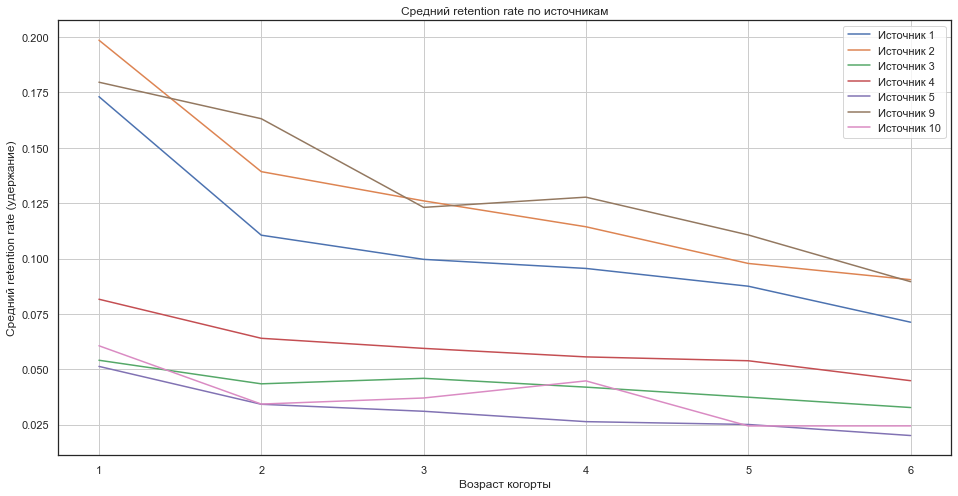

In [58]:
(retention_by_source
    .query('(cohort_month != 0) and (cohort_month <= 6) and (source_id != 6) and (source_id != 7)') # 1-6 возраста когорт, 0-возраст исключен для наглядности графика + исключаем источники 6,7
    .pivot_table(index='cohort_month', columns='source_id', values='retention', aggfunc='mean')
    .plot(title='Средний retention rate по источникам', grid=True)
)

plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Средний retention rate (удержание)')
plt.xlabel('Возраст когорты')
plt.show()

Средняя возвращаемость 1, 2 и, внезапно, 9 источника наиболее высокая, но у 9-го идёт падение с каждой когортой. 

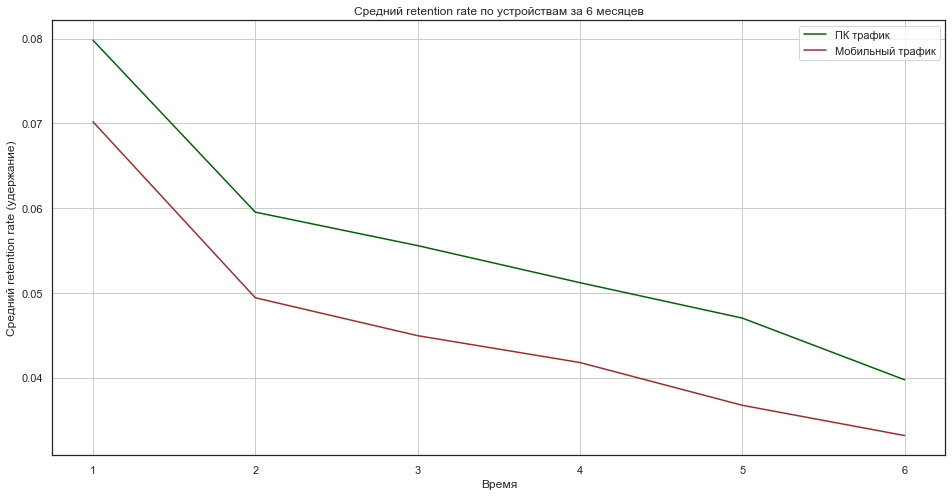

In [59]:
retention_by_device = (visits_log
                       .query('first_session_month <= "2017-11-01"') # 6 месяцев
                       .groupby(['first_session_month','month','device'])
                       .agg({'uid':'nunique'})
                       .reset_index()
                      )
retention_by_device['cohort_month'] = (( retention_by_device['month'] - retention_by_device['first_session_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
initial_users = retention_by_device[retention_by_device['cohort_month'] == 0][['first_session_month','device','uid']]
initial_users = initial_users.rename(columns = {'uid':'cohort_users'})
retention_by_device = retention_by_device.merge(initial_users, on=['first_session_month', 'device'])
retention_by_device['retention'] = retention_by_device['uid']/retention_by_device['cohort_users']

(retention_by_device
    .query('(cohort_month != 0) and (cohort_month <= 6)') # 1-6 возраста когорт, 0-возраст исключен для наглядности графика
    .pivot_table(index='cohort_month', columns='device', values='retention', aggfunc='mean')
    .plot(title='Средний retention rate по устройствам за 6 месяцев', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Средний retention rate (удержание)')
plt.xlabel('Время')
plt.show()

В среднем по каждой когорте возвращаемость падает. Можно увидеть, что люди с ПК в среднем возвращаются больше.

In [60]:
retention_by_source = (visits_log
                       .query('first_session_month <= "2017-11-01"') # 6 месяцев
                       .groupby(['first_session_month','month','source_id'])
                       .agg({'uid':'nunique'})
                       .reset_index()
                      )
retention_by_source['cohort_month'] = (( retention_by_source['month'] - retention_by_source['first_session_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
initial_users = retention_by_source[retention_by_source['cohort_month'] == 0][['first_session_month','source_id','uid']]
initial_users = initial_users.rename(columns = {'uid':'cohort_users'})
retention_by_source = retention_by_source.merge(initial_users, on=['first_session_month','source_id'])
retention_by_source['retention'] = retention_by_source['uid']/retention_by_source['cohort_users']


retention_by_source_and_device = (visits_log
                                  .query('first_session_month <= "2017-11-01"') # 6 месяцев
                                  .groupby(['first_session_month','month','device','source_id'])
                                  .agg({'uid':'nunique'})
                                  .reset_index()
                                 )
retention_by_source_and_device['cohort_month'] = (( retention_by_source_and_device['month'] - retention_by_source_and_device['first_session_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
initial_users = retention_by_source_and_device[retention_by_source_and_device['cohort_month'] == 0][['first_session_month','device','source_id','uid']]
initial_users = initial_users.rename(columns = {'uid':'cohort_users'})
retention_by_source_and_device = retention_by_source_and_device.merge(initial_users, on=['first_session_month', 'device','source_id'])
retention_by_source_and_device['retention'] = retention_by_source_and_device['uid']/retention_by_source_and_device['cohort_users']

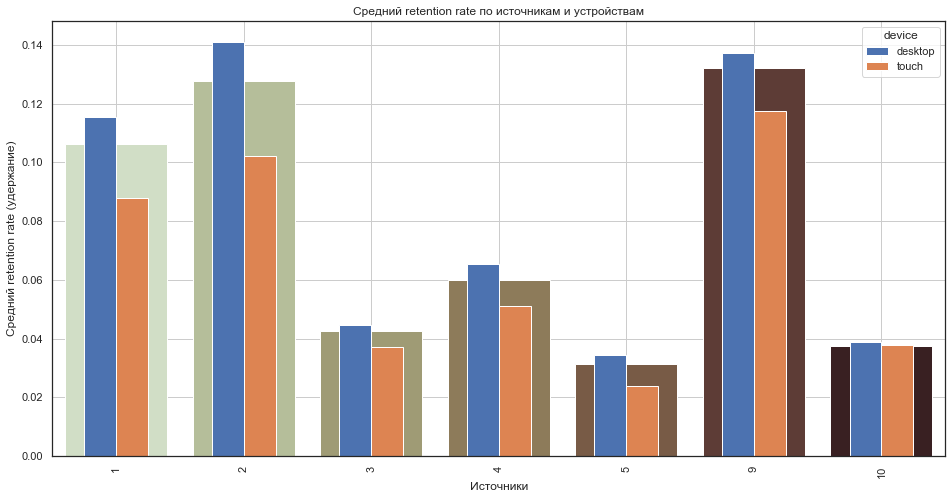

In [61]:
source_df = (retention_by_source
            .query('(cohort_month != 0) and (cohort_month <= 6) and (source_id != 6) and (source_id != 7)')  # 1-6 возраста когорт + исключаем источники 6,7
             .groupby('source_id')
             .agg({'retention':'mean'})
             .reset_index()
            )
source_and_device_df = (retention_by_source_and_device
                        .query('(cohort_month != 0) and (cohort_month <= 6) and (source_id != 6) and (source_id != 7)')  # 1-6 возраста когорт + исключаем источники 6,7
                        .groupby(['source_id','device'])
                        .agg({'retention':'mean'})
                        .reset_index()
                        .pivot_table(index='source_id', columns='device', values='retention', aggfunc='mean')
                       )


ax = sns.barplot(x='source_id', y='retention',  palette="ch:.7", data=source_df)
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)

plt.title('Средний retention rate по источникам и устройствам')
plt.ylabel('Средний retention rate (удержание)')
plt.xlabel('Источники')
plt.show()

Подведем итог: 1,2,9 источники приводят трафик, который возвращается чаще. Особенно в 1 и 2 источнике выделяется ПК-трафик.

In [62]:
mean_retention = visits_by_cohorts.query('(cohort_month > 0)')
print(f'Общий средний Retention rate за всё время:{(mean_retention["retention"].mean()):.2%}') 

Общий средний Retention rate за всё время:4.45%


Иногда проще держать в голове 1 цифру и в будущем сталкивась с показателями выше или ниже - понимать насколько всё хорошо или плохо. Например Retention rate - 4,5%

---

<h3 align='center'><font color="#173b3f"> Когда люди начинают покупать? </font></h3><br>

Здесь можно рассмотреть "когда?" имея ввиду "через какое время после первой сессии?" и "когда?" в смысле "через сколько сессий?"

Я рассматрю оба случая.

#### Итак, через какое время после первой сессии совершают первую покупку?

In [63]:
orders_log['buy_day'] = orders_log['buy_ts'].dt.floor('1d')
first_buy_date = orders_log.groupby(['uid'])['buy_ts'].min() # выявляем даты первой покупки
first_buy_date.name = 'first_buy_date'
orders_log = orders_log.join(first_buy_date,on='uid') # соединяем с основной таблицей
orders_log.head(3)

buy_ts  revenue                   uid    buy_day  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01   

       first_buy_date  
0 2017-06-01 00:10:00  
1 2017-06-01 00:25:00  
2 2017-06-01 00:27:00

In [64]:
visits_and_orders = visits_log.merge(orders_log, on='uid') # соединяем с таблицей с визитами
visits_and_orders['duration_to_buy'] = (
    ((visits_and_orders['first_buy_date'] - visits_and_orders['first_session']) / np.timedelta64(1, 's'))
    .round()
    .astype('int')
) # добавили столбец с длительностью от первой сессии до первой продажи в секундах
visits_and_orders.head(3)

device              end_ts  source_id            start_ts  \
0  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
1  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
2  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   

                    uid        day       week      month  duration_ts  \
0  16174680259334210214 2018-05-20 2018-05-17 2018-05-01       1440.0   
1  16174680259334210214 2018-03-09 2018-03-08 2018-03-01       1680.0   
2  16007536194108375387 2017-09-03 2017-08-31 2017-09-01         60.0   

        first_session first_session_month              buy_ts  revenue  \
0 2018-03-09 20:05:00          2018-03-01 2018-03-09 20:25:00     2.33   
1 2018-03-09 20:05:00          2018-03-01 2018-03-09 20:25:00     2.33   
2 2017-09-03 21:35:00          2017-09-01 2017-09-04 12:46:00     2.44   

     buy_day      first_buy_date  duration_to_buy  
0 2018-03-09 2018-03-09 20:25:00             1200  
1 2018-03-09 2018-03-09 20:25:00             1200  
2 2017-09-04 2017-09-04 12:46:00            54660

In [65]:
print(f"Среднее время до покупки за исследуемое время (1 год) составляет {int(round(visits_and_orders['duration_to_buy'].mean()/60/60/24))} дней")

Среднее время до покупки за исследуемое время (1 год) составляет 18 дней


Целых 18 дней, НО! Это всё равно, что считать среднюю температуру по больнице. Например посмотрим на медиану:

In [66]:
print(f"Медианное время до покупки за исследуемое время составляет {int(round(visits_and_orders['duration_to_buy'].median()/60/60/24))} дня")

Медианное время до покупки за исследуемое время составляет 2 дня


Уже 2 дня! Т.е. половина людей совершивших покупку, совершили её посетив сайт не более 2 дней назад. Ну и соответственно во второй половине людей есть те, кто покупал первый раз через несколько месяцев и даже через год:

In [67]:
print(f"Максимальное время до покупки за исследуемое время составляет {int(round(visits_and_orders['duration_to_buy'].max()/60/60/24))} дня")

Максимальное время до покупки за исследуемое время составляет 363 дня


Теперь посмотрим как это всё выглядит на графике

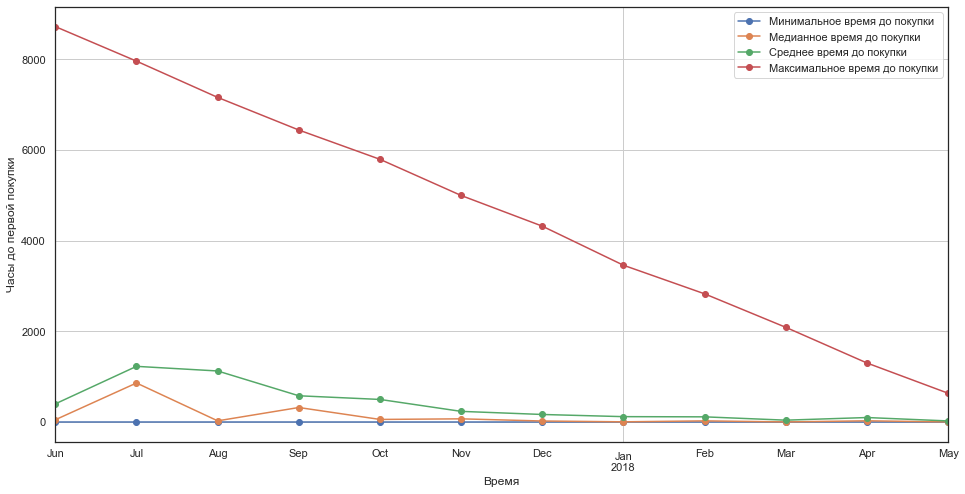

In [68]:
visits_and_orders['duration_to_buy_hours'] = (visits_and_orders['duration_to_buy']/60/60).round(2)

(visits_and_orders
    .sort_values('duration_to_buy_hours')
    .pivot_table(index='first_session_month', values='duration_to_buy_hours', aggfunc=['min','median','mean','max'])
    .plot(style='o-', grid=True, figsize=(16,8))
)

plt.legend(['Минимальное время до покупки','Медианное время до покупки','Среднее время до покупки','Максимальное время до покупки'])
plt.ylabel('Часы до первой покупки')
plt.xlabel('Время')
plt.show()

На этом графике явно видно, что разброс во времени может достигать максимально возможного из рассматриваемого периода, т.е. не важно когда человек первый раз посетил сайт, он может купить в любое время. Теперь рассмотрим медиану и среднее значение поближе:

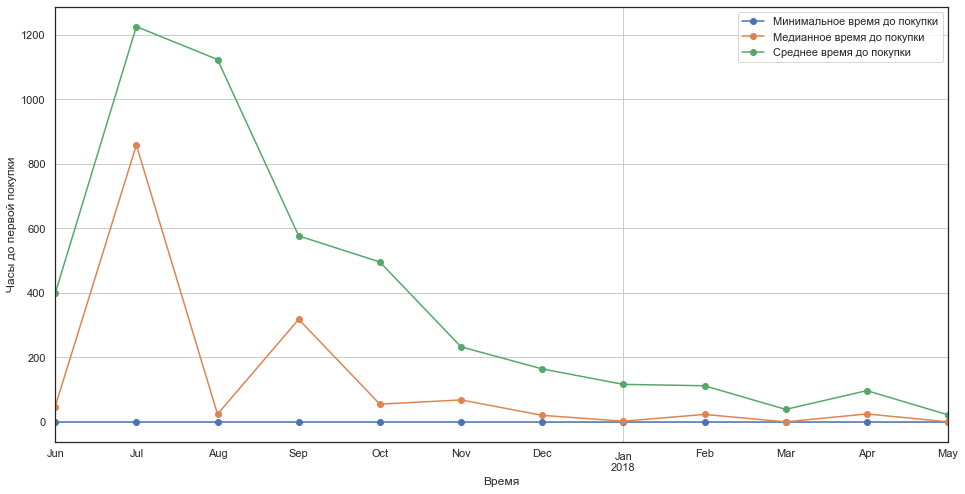

In [69]:
(visits_and_orders
    .sort_values('duration_to_buy_hours')
    .pivot_table(index='first_session_month', values='duration_to_buy_hours', aggfunc=['min','median','mean'])
    .plot(style='o-', grid=True, figsize=(16,8))
)

plt.legend(['Минимальное время до покупки','Медианное время до покупки','Среднее время до покупки'])
plt.ylabel('Часы до первой покупки')
plt.xlabel('Время')
plt.show()

Минимальное время от посещения до покупки всё так же на нуле, часть людей покупают сразу или не дают себя корректно отслеживать, таким образом время сеанса и покупки - одно и то же. Средняя и медиана первых месяцев поднимаются с течением времени, чем больше человек покупают всё позже и позже - тем сильнее увеличиваются эти показатели.

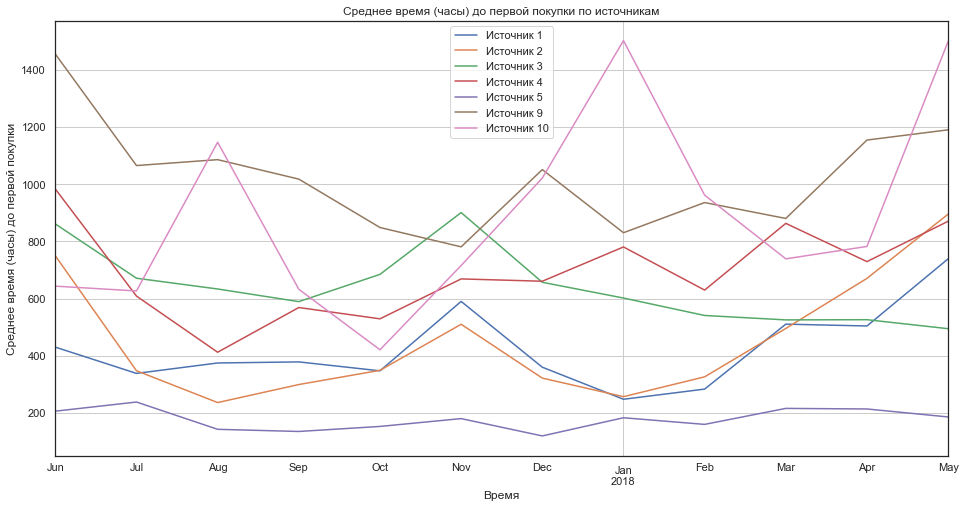

In [70]:

(visits_and_orders
    .query('(source_id != 6) and (source_id != 7)')
    .groupby(['source_id','month'])['duration_to_buy_hours']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='source_id', values='duration_to_buy_hours', aggfunc='mean')
    .plot(title='Среднее время (часы) до первой покупки по источникам', grid=True)
)
plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Среднее время (часы) до первой покупки')
plt.xlabel('Время')
plt.show()

Наиболее быстро покупают люди из 5-то источника, и это сохраняется на протяжении всего года. Так же быстро принимают решения люди из 1 и 2 источника, но в последние месяцы они начали долго думать, так же 3 источник подаёт надежды на быструю отдачу от вложений в него (время до покупки падает)

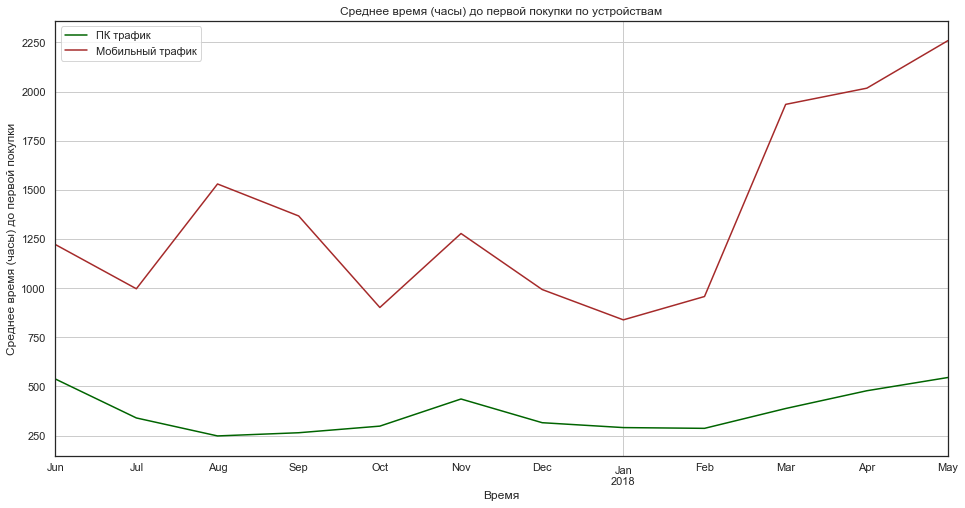

In [71]:
(visits_and_orders
    .query('(source_id != 6) and (source_id != 7)')
    .groupby(['device','month'])['duration_to_buy_hours']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='device', values='duration_to_buy_hours', aggfunc='mean')
    .plot(title='Среднее время (часы) до первой покупки по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Среднее время (часы) до первой покупки')
plt.xlabel('Время')
plt.show()

На ПК люди покупают намного быстрее, и ситуация сохраняется на протяжении года. А на мобильных люди всё дольше принимают решения.

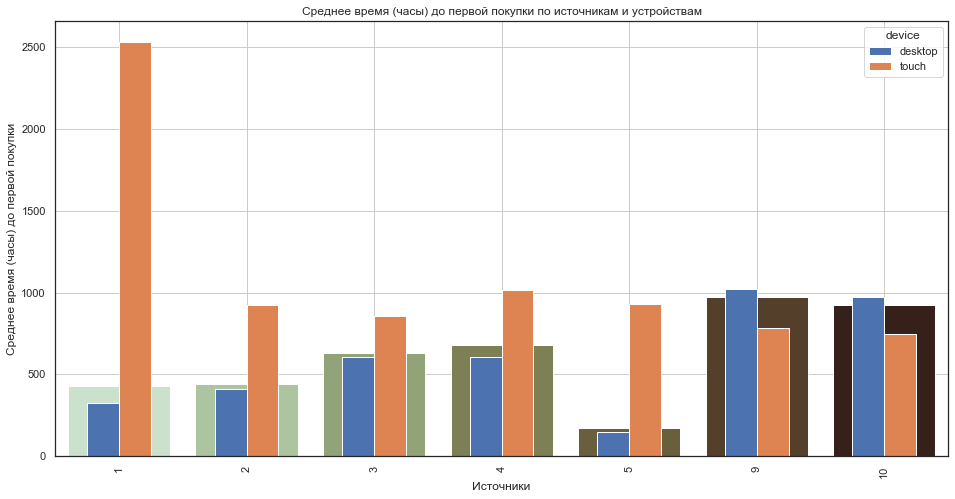

In [72]:
source_df = (visits_and_orders
             .query('(source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'duration_to_buy_hours':'mean'})
             .reset_index()
            )

source_and_device_df = (visits_and_orders
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'duration_to_buy_hours':'mean'})
                        .reset_index()
                        .pivot_table(index='source_id', columns='device', values='duration_to_buy_hours', aggfunc='mean')
                       )


ax = sns.barplot(x='source_id', y='duration_to_buy_hours',  palette="ch:.9", data=source_df)
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)

plt.title('Среднее время (часы) до первой покупки по источникам и устройствам')
plt.ylabel('Среднее время (часы) до первой покупки')
plt.xlabel('Источники')
plt.show()

1 и 5 источник дают наиболее быстропокупающих людей, но всю статистику портит мобильный трафик, возможно в рекламе стоит сократить расходы на мобильных пользователей (например в Яндекс.Директ есть такой инструмент как корректировка ставок на устройства). И нужно заняться доработкой мобильной версии сайта, запускать А/Б-тесты для поиска решения, когда люди будут покупать быстрее и чаще.

---

#### Теперь посмотрим на какой по счёту сеанс покупают

In [73]:
sessions_before_buy = ( 
    visits_and_orders[visits_and_orders['start_ts'] <= visits_and_orders['first_buy_date']] #отсекли все сессии после первой покупки
    .groupby(['uid', 'first_buy_date'])['start_ts'] # берем уников с их днями первой покупки и третьим столбцом пишем количество сессий до покупки включительно
    .count()
    .reset_index()
)

sessions_before_buy = sessions_before_buy.rename(columns = {'start_ts':'sessions_before_buy'})
sessions_before_buy.sort_values('first_buy_date').head(10)

uid      first_buy_date  sessions_before_buy
20437  10329302124590727494 2017-06-01 00:10:00                    1
23018  11627257723692907447 2017-06-01 00:25:00                    1
35477  17903680561304213844 2017-06-01 00:27:00                    1
31908  16109239769442553005 2017-06-01 00:29:00                    1
28100  14200605875248379450 2017-06-01 07:58:00                    1
20576  10402394430196413321 2017-06-01 08:43:00                    1
24667  12464626743129688638 2017-06-01 08:54:00                    2
34755  17542070709969841479 2017-06-01 09:22:00                    1
7206    3644482766749211722 2017-06-01 09:22:00                  239
2075    1074355127080856382 2017-06-01 09:23:00                    1

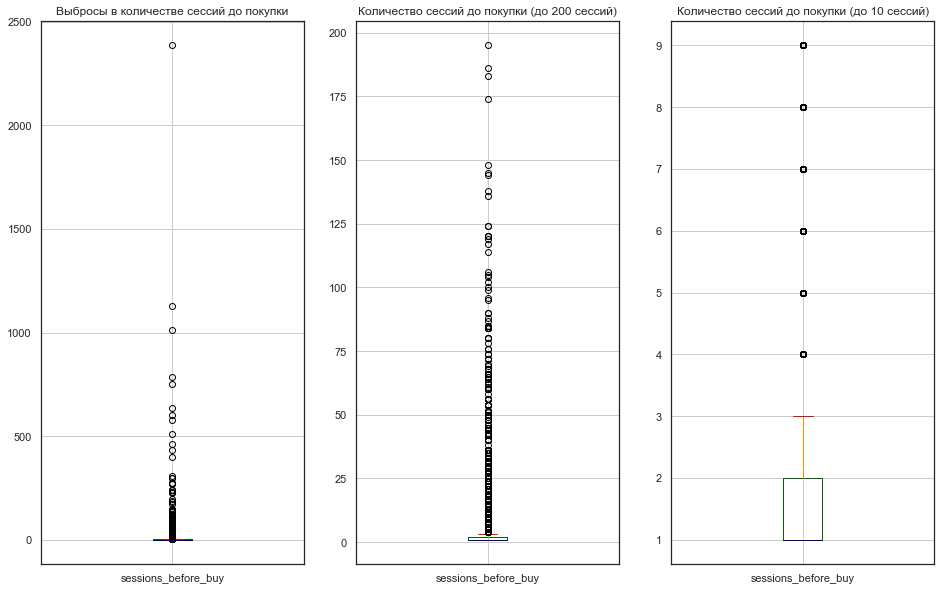

In [74]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Red'}
fig, axes = plt.subplots(1, 3, figsize=(16, 10))

(sessions_before_buy
    .plot.box(x='first_buy_date', y='sessions_before_buy', title='Выбросы в количестве сессий до покупки', grid=True, ax=axes[0], color=color)
)
(sessions_before_buy
    .query('sessions_before_buy < 200')
    .plot.box(x='first_buy_date', y='sessions_before_buy', title='Количество сессий до покупки (до 200 сессий)', grid=True, ax=axes[1], color=color)
)
(sessions_before_buy
    .query('sessions_before_buy < 10')
    .plot.box(x='first_buy_date', y='sessions_before_buy', title='Количество сессий до покупки (до 10 сессий)', grid=True, ax=axes[2], color=color)
)
plt.show()

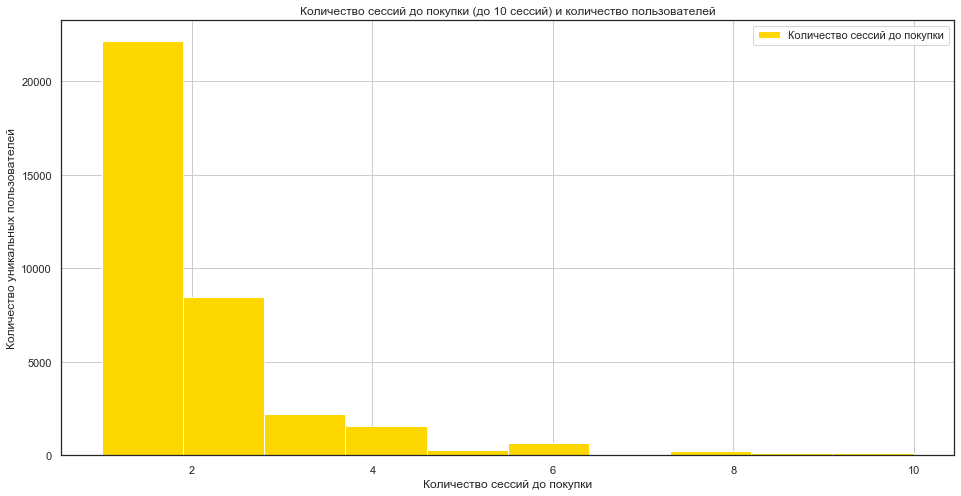

In [75]:
(sessions_before_buy
    .sort_values('first_buy_date')
    .query('sessions_before_buy <= 10')
    .plot.hist(x='first_buy_date', y='sessions_before_buy', title='Количество сессий до покупки (до 10 сессий) и количество пользователей', grid=True, color='gold', figsize=(16,8))
)

plt.legend(['Количество сессий до покупки'])
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Количество сессий до покупки')
plt.show()

In [76]:
print(f"Количество людей купивших в первые 4 сессий: {sessions_before_buy[sessions_before_buy['sessions_before_buy'] <= 4]['uid'].count()}")
print(f"Количество людей купивших на 5-ю и более сессий: {sessions_before_buy[sessions_before_buy['sessions_before_buy'] > 4]['uid'].count()}")

Количество людей купивших в первые 4 сессий: 34413
Количество людей купивших на 5-ю и более сессий: 2110


Боксплоты показывают, что присутствуют сильные выбросы, но количество людей купивших с 1-й по 4-ю сессии - подавляющее большинство, и лишь ~6% совершают покупки позже.

Посмотрим, влияет ли время на то как быстро (за какое количество сессий) человек принимает решение купить

In [77]:
sessions_before_buy[sessions_before_buy['sessions_before_buy'] > 200]['sessions_before_buy'].count() # выбросы


24

Этих 24 пользователей я учитывать не буду, аномально много они думали перед покупкой (> 200)

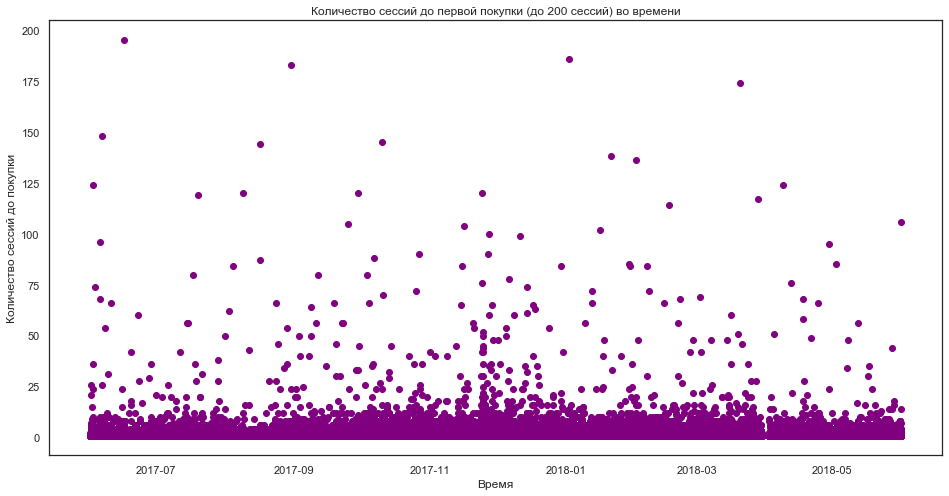

In [78]:
sessions_before_buy_plot =(sessions_before_buy
    .sort_values('first_buy_date')
    .query('sessions_before_buy < 200')
    #.plot.scatter(x='date_num', y='sessions_before_buy', title='Количество сессий до покупки (до 200 сессий) в разное время', grid=True, color='purple', figsize=(16,8))  
)
plt.plot_date(sessions_before_buy_plot['first_buy_date'], sessions_before_buy_plot['sessions_before_buy'], color='purple')
plt.title('Количество сессий до первой покупки (до 200 сессий) во времени')
plt.ylabel('Количество сессий до покупки')
plt.xlabel('Время')
plt.show()

Как видно из графика, во все времена люди могут как сразу принимать решение о покупке, так и возвращаться десятки раз до принятия решения или поиска нужного билета. Но как мы выяснили ранее, почти 90% людей которые купили - сделали это в первые сеансы

In [79]:
sessions_before_buy_by_source = visits_log.merge(sessions_before_buy, on=['uid'] )
sessions_before_buy_by_source.head()

device              end_ts  source_id            start_ts  \
0  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
1  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
2  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
3  desktop 2017-10-27 16:02:00          3 2017-10-27 15:20:00   
4  desktop 2017-09-04 17:56:00          4 2017-09-04 17:37:00   

                    uid        day       week      month  duration_ts  \
0  16174680259334210214 2018-05-20 2018-05-17 2018-05-01       1440.0   
1  16174680259334210214 2018-03-09 2018-03-08 2018-03-01       1680.0   
2  16007536194108375387 2017-09-03 2017-08-31 2017-09-01         60.0   
3  16007536194108375387 2017-10-27 2017-10-26 2017-10-01       2520.0   
4  16007536194108375387 2017-09-04 2017-08-31 2017-09-01       1140.0   

        first_session first_session_month      first_buy_date  \
0 2018-03-09 20:05:00          2018-03-01 2018-03-09 20:25:00   
1 2018-03-09 20:05:00          2018-03-01 2018-03-09 20:25:00   
2 2017-09-03 21:35:00          2017-09-01 2017-09-04 12:46:00   
3 2017-09-03 21:35:00          2017-09-01 2017-09-04 12:46:00   
4 2017-09-03 21:35:00          2017-09-01 2017-09-04 12:46:00   

   sessions_before_buy  
0                    1  
1                    1  
2                    9  
3                    9  
4                    9

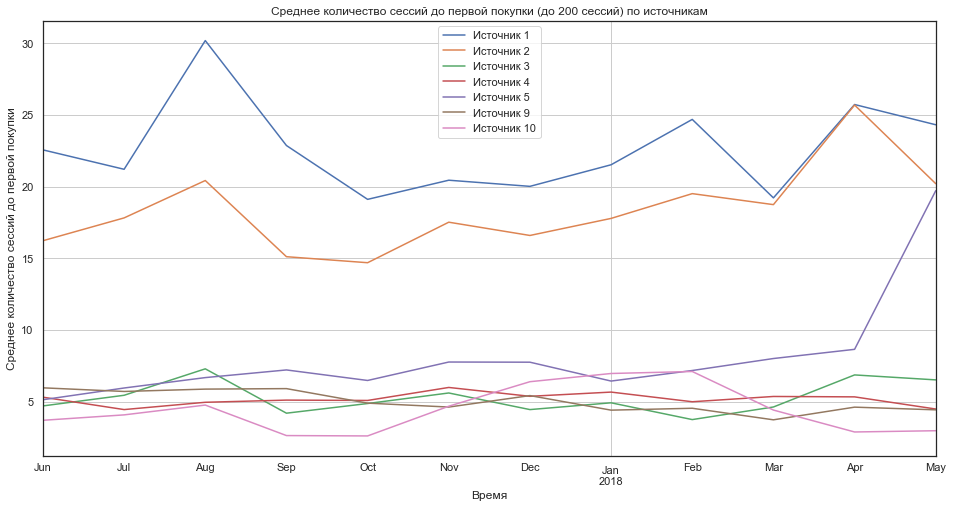

In [80]:
(sessions_before_buy_by_source
    .query('(sessions_before_buy < 200) and (source_id != 6) and (source_id != 7)')
    .groupby(['source_id','month'])['sessions_before_buy']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='source_id', values='sessions_before_buy', aggfunc='mean')
    .plot(title='Среднее количество сессий до первой покупки (до 200 сессий) по источникам', grid=True)
)

plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Среднее количество сессий до первой покупки')
plt.xlabel('Время')
plt.show()

Основной трафик не решительных и интересующихся приводят 1 и 2 источники. По остальным приходят люди, которые покупают на 5+/- 2 сеанса. Не забываем, что я ограничил здесь количество сессий до покупки до 200, т.е. если сделать срез на "до 10 сеансов" до покупки, ситуация изменится и окажется, что наиболее решительных людей дает 10 источник

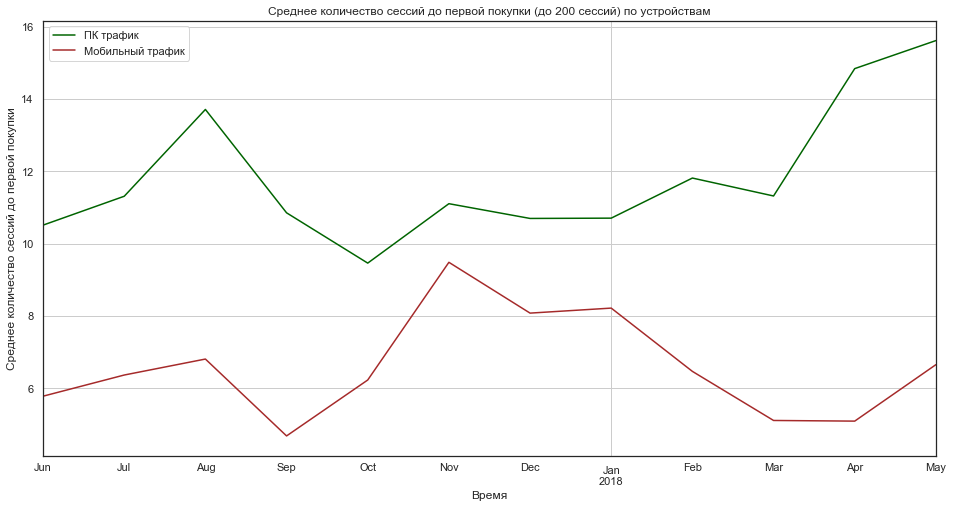

In [81]:
(sessions_before_buy_by_source
    .query('(sessions_before_buy < 200) and (source_id != 6) and (source_id != 7)')
    .groupby(['device','month'])['sessions_before_buy']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='device', values='sessions_before_buy', aggfunc='mean')
    .plot(title='Среднее количество сессий до первой покупки (до 200 сессий) по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Среднее количество сессий до первой покупки')
plt.xlabel('Время')
plt.show()

А вот здесь мобильные устройства вырывают пальму первенства у ПК. Как мы помним по времени пользователи мобильных принимают решение долго, но зато делают это чаще в первые сеансы. В зимние месяцы этот показатель приближается к ПК-версии и нужно отметить, что разница давольно большая между сентябрем (3 сессии до пукпки) и ноябрем (9 сессий до покупки), возможно ещё потому что в ноябре на черную пятницу набежало много людей обновляющих сайт в поисках халявы.

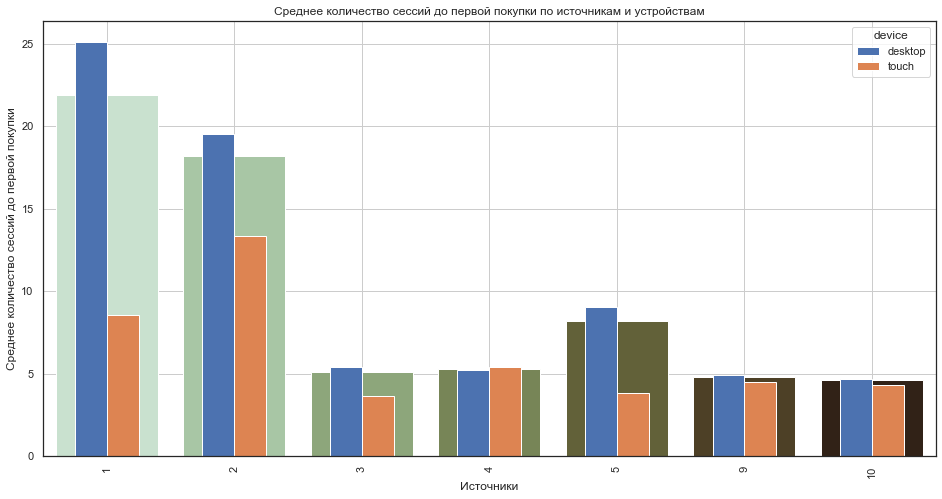

In [82]:
source_df = (sessions_before_buy_by_source
             .query('(sessions_before_buy < 200) and (source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'sessions_before_buy':'mean'})
             .reset_index()
            )

source_and_device_df = (sessions_before_buy_by_source
                        .query('(sessions_before_buy < 200) and (source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'sessions_before_buy':'mean'})
                        .reset_index()
                        .pivot_table(index='source_id', columns='device', values='sessions_before_buy', aggfunc='mean')
                       )

ax = sns.barplot(x='source_id', y='sessions_before_buy',  palette="ch:1.0", data=source_df)
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)

plt.title('Среднее количество сессий до первой покупки по источникам и устройствам')
plt.ylabel('Среднее количество сессий до первой покупки')
plt.xlabel('Источники')
plt.show()

Итого: 3,4,9,10 источники дают наиболее быстрых (с точки зрения количества сессий) покупателей. Статистику 1,2 и 5 источников портят ПК-покупатели, коготые очень много раз возвращаются перед первой покупкой. Возможно на ПК приходят люди которые ищут "куда бы сходить", а на мобильную версию приходят те, кто уже знают куда идти и покупают быстрее.

---

<h3 align='center'><font color="#173b3f"> Сколько раз покупают за период? </font></h3><br>

Тут нам понадобятся месяцы у каждой покупки в orders_log, чтобы поделить по когортам

In [83]:
orders_log['first_buy_month'] = orders_log['first_buy_date'].astype('datetime64[M]')
orders_log['buy_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_log.head(3)

buy_ts  revenue                   uid    buy_day  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01   

       first_buy_date first_buy_month  buy_month  
0 2017-06-01 00:10:00      2017-06-01 2017-06-01  
1 2017-06-01 00:25:00      2017-06-01 2017-06-01  
2 2017-06-01 00:27:00      2017-06-01 2017-06-01

Кроме нужных показателей: числа уникальных покупателей, и числа покупок, добавлю в таблицу сумму дохода для будущих исследований

In [84]:
orders_by_cohorts = orders_log.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum','buy_ts':'count','uid':'nunique'}).reset_index()
orders_by_cohorts['cohort_month'] = (( orders_by_cohorts['buy_month'] - orders_by_cohorts['first_buy_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
orders_by_cohorts = orders_by_cohorts.rename(columns = {'revenue':'revenue_sum','buy_ts':'buy_count','uid':'uid_count'})
orders_by_cohorts.head()

first_buy_month  buy_month  revenue_sum  buy_count  uid_count  cohort_month
0      2017-06-01 2017-06-01      9557.49       2354       2023             0
1      2017-06-01 2017-07-01       981.82        177         61             1
2      2017-06-01 2017-08-01       885.34        174         50             2
3      2017-06-01 2017-09-01      1931.30        226         54             3
4      2017-06-01 2017-10-01      2068.58        292         88             4

In [85]:
orders_by_cohorts['first_buy_month'] = orders_by_cohorts['first_buy_month'].dt.strftime('%Y-%m')

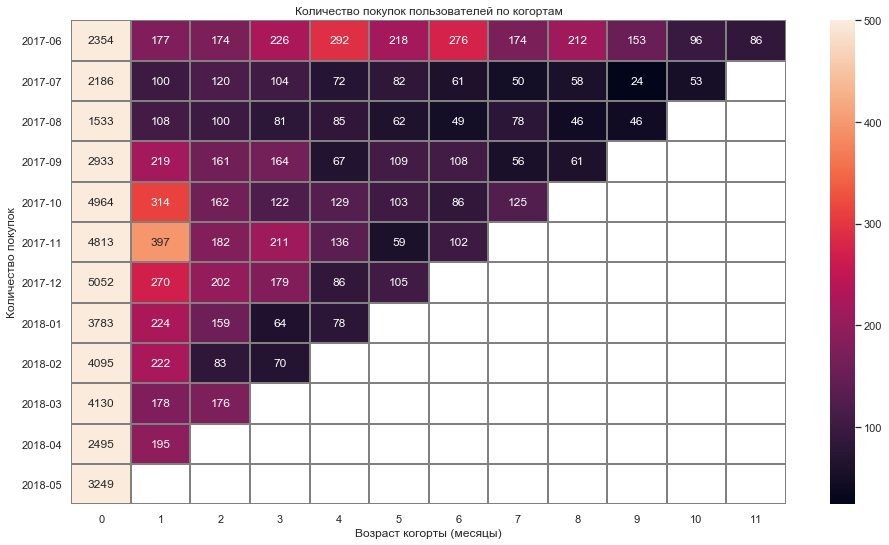

In [86]:
orders_per_user_pivot = (orders_by_cohorts
    .query('first_buy_month < "2018-06"') # 2018-06 - этот месяц не полный, там всего 1 покупка
    .pivot_table(index='first_buy_month',columns='cohort_month',values='buy_count',aggfunc='mean')

)
plt.figure(figsize=(16, 8.9))

sns.heatmap(orders_per_user_pivot, vmax=500, fmt='.0f',annot=True, linewidths=1, linecolor='gray')

plt.title('Количество покупок пользователей по когортам')
plt.ylabel('Количество покупок')
plt.xlabel('Возраст когорты (месяцы)')
plt.show()

Много людей из июньской когорты совершают повторные покупки и через несколько месяцев, но в целом их было мало - 2354, для сравнения в декабре когорта составила 5052 покупок от уникальных пользователей. Ещё интересно, что люди пришедшие в ноябре (когда была черная пятница) вернулись за покупками и в декабре, более охотно чем другие когорты на следующий месяц.

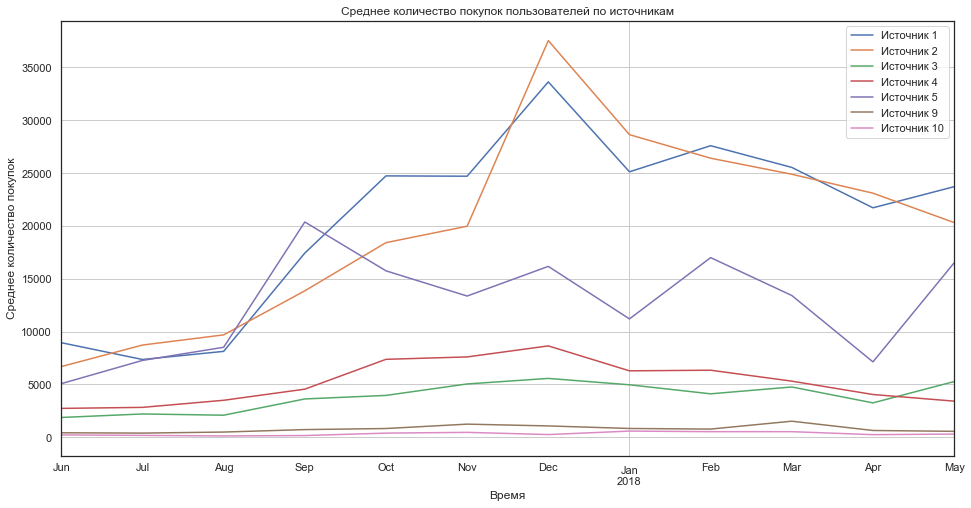

In [87]:
((visits_and_orders
                  .groupby(['month', 'source_id'])
                  .agg({'buy_ts':'count'})
                  .reset_index()
                  .rename(columns = {'buy_ts':'buy_count'})
             )
    .query('(source_id != 6) and (source_id != 7)') # у 6,7 источника мало данных, график не отражает реальность
    .groupby(['month', 'source_id'])['buy_count']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='source_id', values='buy_count', aggfunc='mean')
    .plot(title='Среднее количество покупок пользователей по источникам', grid=True)
)

plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Среднее количество покупок')
plt.xlabel('Время')
plt.show()

1 и 2 источники в среднем приводят больше покупок (повторных в том числе)

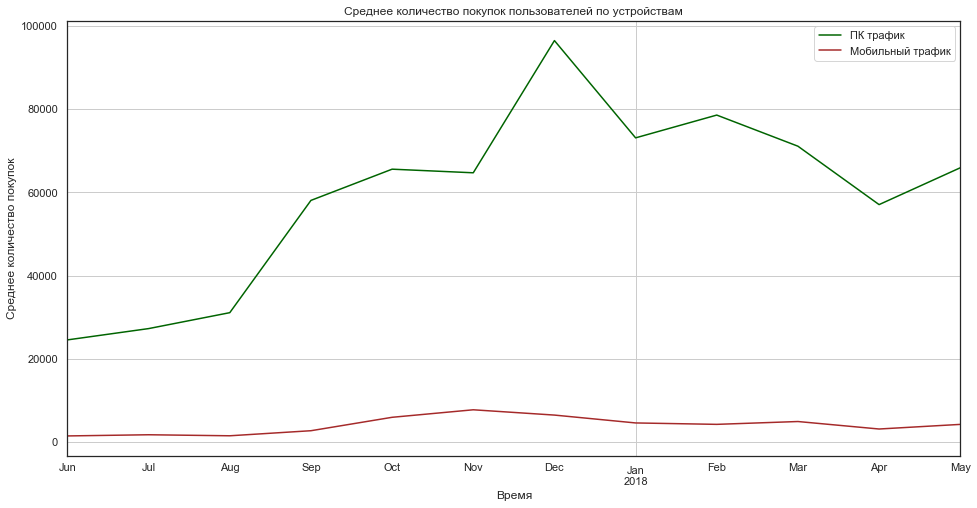

In [88]:
((visits_and_orders
                  .groupby(['month', 'device'])
                  .agg({'buy_ts':'count'})
                  .reset_index()
                  .rename(columns = {'buy_ts':'buy_count'})
             )
    .groupby(['month', 'device'])['buy_count']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='device', values='buy_count', aggfunc='mean')
    .plot(title='Среднее количество покупок пользователей по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Среднее количество покупок')
plt.xlabel('Время')
plt.show()

ПК - лучший способ выбирать покупку, здесь нет сомнений, что даже те, кто изначально покупал на мобильном, потом перешли на ПК.

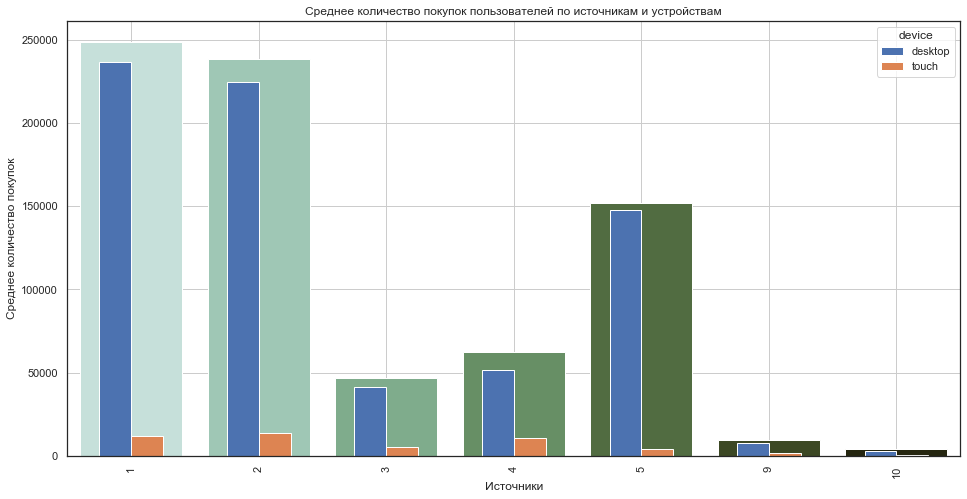

In [89]:
source_df = ((visits_and_orders
                  .groupby('source_id')
                  .agg({'buy_ts':'count'})
                  .reset_index()
                  .rename(columns = {'buy_ts':'buy_count'})
             )
             .query('(source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'buy_count':'mean'})
             .reset_index()
            )
source_and_device_df = ((visits_and_orders.groupby(['source_id','device'])
                             .agg({'buy_ts':'count'})
                             .reset_index()
                             .rename(columns = {'buy_ts':'buy_count'})
                        )
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'buy_count':'mean'})
                        .reset_index()
                       )


plt.title('Среднее количество покупок пользователей по источникам и устройствам')
ax = sns.barplot(x='source_id', y='buy_count',  palette="ch:1.3", data=source_df)

(source_and_device_df
         .pivot_table(index='source_id', columns='device', values='buy_count', aggfunc='mean')
         .plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)
)

plt.ylabel('Среднее количество покупок')
plt.xlabel('Источники')
plt.show()

1,2,5 источники лидируют по количеству покупок. Здесь видно на сколько ПК сильно лидирует по отношению к мобильным устройствам. А 9 и 10 источники приводят очень мало покупок, возможно это не популярные каналы.

In [90]:
orders_per_user_mean = (orders_by_cohorts
                        .query('(cohort_month <= 6) and (first_buy_month <= "2017-11")')
                        .groupby('first_buy_month')
                        .agg({'uid_count':'max','buy_count':'sum'})
                        .reset_index()
                       )
orders_per_user_mean['orders_per_user'] = (orders_per_user_mean['buy_count'] / orders_per_user_mean['uid_count']).round(2)
print()
print('Среднее количество покупок на пользователя по когортам за 6 месяцев')
orders_per_user_mean.head()


Среднее количество покупок на пользователя по когортам за 6 месяцев


first_buy_month  uid_count  buy_count  orders_per_user
0         2017-06       2023       3717             1.84
1         2017-07       1923       2725             1.42
2         2017-08       1370       2018             1.47
3         2017-09       2581       3761             1.46
4         2017-10       4340       5880             1.35

In [91]:
print(f"Среднее число покупок на человека за 6 месяцев: {(orders_per_user_mean['buy_count'].sum() / orders_per_user_mean['uid_count'].sum()).round(2)}")

Среднее число покупок на человека за 6 месяцев: 1.47


Т.е. вероятнее всего 1 человек совершит 1 покупку и лишь в когорте за июнь 2017 люди были особо активными и покупали чаще, почти 2 покупки совершал каждый человек в среднем за 6 месяцев.

Для наглядности покажу ещё одну таблицу, которая расставит все точки над i :

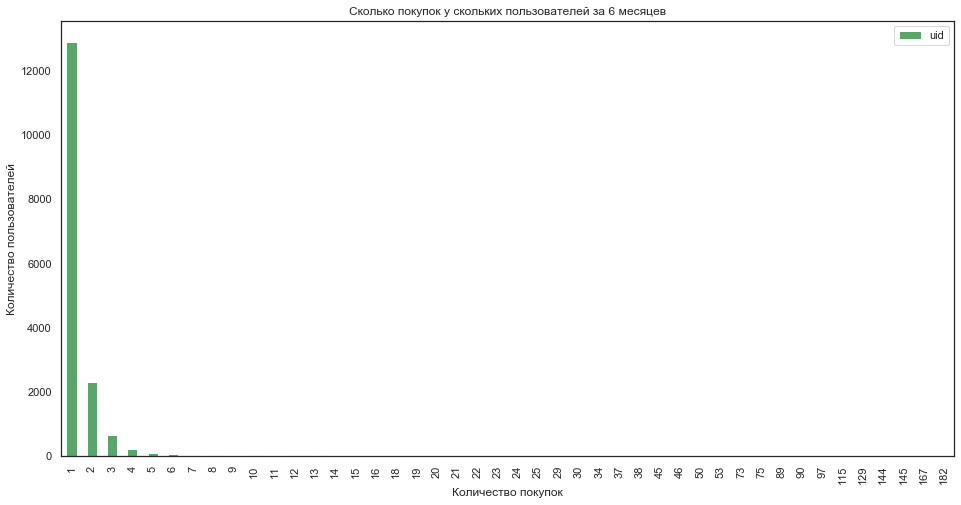

In [92]:
orders_mean = (orders_log
               .groupby(['first_buy_month','buy_month','uid'])
               .agg({'buy_ts':'count'})
               .reset_index()
              )
orders_mean['cohort_month'] = (( orders_mean['buy_month'] - orders_mean['first_buy_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
orders_mean = orders_mean.rename(columns = {'buy_ts':'buy_count'})
orders_mean = orders_mean.query('(cohort_month <= 6) and (first_buy_month <= "2017-11")')
orders_mean = orders_mean.groupby(['uid']).agg({'buy_count':'sum'}).sort_values('buy_count', ascending=False).reset_index()

orders_mean.groupby(['buy_count']).count().reset_index().plot(x='buy_count', y='uid', kind='bar', color='g')

plt.title('Сколько покупок у скольких пользователей за 6 месяцев')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество покупок')
plt.show()

Дополнительный график, показывающий сколько покупок у скольких пользователей. Здесь видно, что большинство покупало 1 раз, а 6 и более покупок совершают еденицы

---

<h3 align='center'><font color="#173b3f"> Какой средний чек? </font></h3><br>

In [93]:
orders_by_cohorts['average_bill'] = orders_by_cohorts['revenue_sum'] / orders_by_cohorts['buy_count'] # средний чек
orders_by_cohorts.tail()

first_buy_month  buy_month  revenue_sum  buy_count  uid_count  \
74         2018-03 2018-05-01      1114.87        176         58   
75         2018-04 2018-04-01     10600.69       2495       2276   
76         2018-04 2018-05-01      1209.92        195         69   
77         2018-05 2018-05-01     13925.76       3249       2988   
78         2018-06 2018-06-01         3.42          1          1   

    cohort_month  average_bill  
74             2      6.334489  
75             0      4.248774  
76             1      6.204718  
77             0      4.286168  
78             0      3.420000

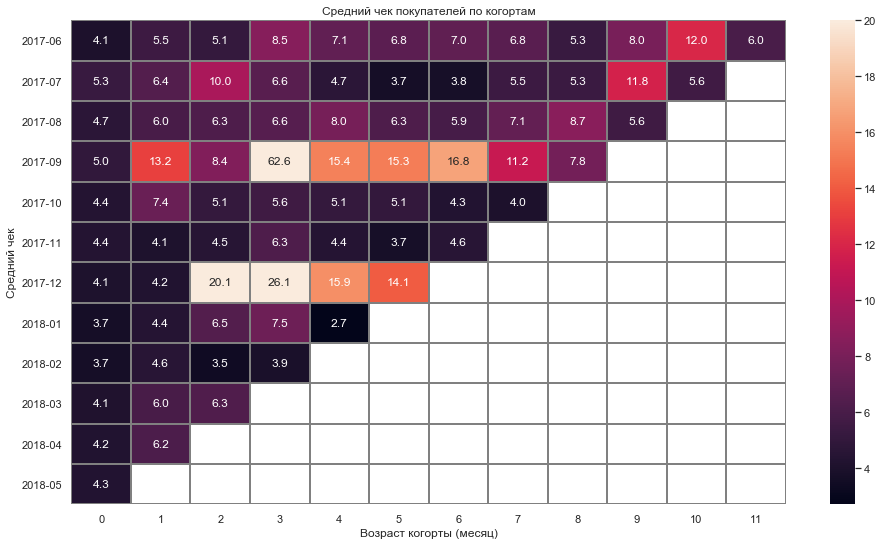

In [94]:
average_bill_pivot = (orders_by_cohorts
    .query('first_buy_month < "2018-06"') # 2018-06 - этот месяц не полный, там всего 1 покупка
    .pivot_table(index='first_buy_month',columns='cohort_month',values='average_bill',aggfunc='mean')

)
plt.figure(figsize=(16, 8.9))

sns.heatmap(average_bill_pivot, vmax=20, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

plt.title('Средний чек покупателей по когортам')
plt.ylabel('Средний чек')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

Когорты сентября и декабря очень удачные, их средние чеки наерняка отбивают затраты по ним уже через полгода, это мы ещё увидим. Особенно выделяется сентябрьская когорта в декабре, в 10 раз превышая показатели почти всех других когорт.

In [95]:
visits_and_orders['first_buy_month'] = visits_and_orders['first_buy_date'].astype('datetime64[M]')
visits_and_orders['buy_month'] = visits_and_orders['buy_ts'].astype('datetime64[M]')

orders_by_cohorts_and_source = visits_and_orders.groupby(['first_buy_month', 'buy_month', 'source_id']).agg({'revenue':'sum','buy_ts':'count','uid':'nunique'}).reset_index()
orders_by_cohorts_and_source['cohort_month'] = (( orders_by_cohorts_and_source['buy_month'] - orders_by_cohorts_and_source['first_buy_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта
orders_by_cohorts_and_source = orders_by_cohorts_and_source.rename(columns = {'buy_ts':'buy_count','uid':'uid_count'})
orders_by_cohorts_and_source['average_bill'] = orders_by_cohorts_and_source['revenue'] / orders_by_cohorts_and_source['buy_count'] # средний чек
orders_by_cohorts_and_source.head()

first_buy_month  buy_month  source_id   revenue  buy_count  uid_count  \
0      2017-06-01 2017-06-01          1  51524.95       9364        401   
1      2017-06-01 2017-06-01          2  49626.01       7379        457   
2      2017-06-01 2017-06-01          3   7467.82       1683        874   
3      2017-06-01 2017-06-01          4  13644.17       2273        644   
4      2017-06-01 2017-06-01          5  23407.59       4524        571   

   cohort_month  average_bill  
0             0      5.502451  
1             0      6.725303  
2             0      4.437207  
3             0      6.002714  
4             0      5.174092

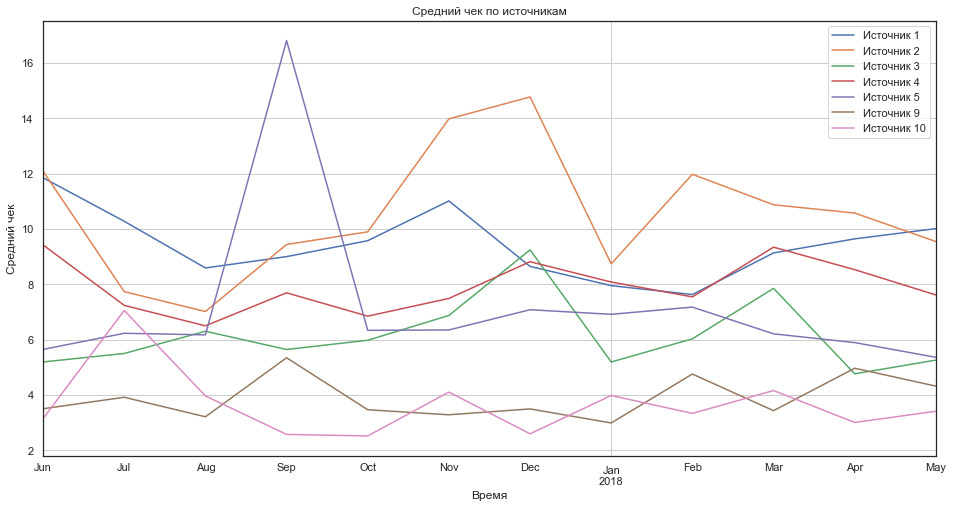

In [96]:
orders_by_source = (visits_and_orders
                      .groupby(['month', 'source_id'])
                      .agg({'revenue':'sum','buy_ts':'count'})
                      .reset_index()
                    )
orders_by_source['average_bill'] = orders_by_source['revenue'] / orders_by_source['buy_ts']

(orders_by_source
    .query('(source_id != 6) and (source_id != 7)')
    .groupby(['month', 'source_id'])
    .agg({'average_bill':'max'}) # декоративная функция - ничего не делает (можно вписать любую), но позваляет создть график
    .reset_index()
    .pivot_table(index='month', columns='source_id', values='average_bill', aggfunc='max')
    .plot(title='Средний чек по источникам', grid=True)
)

plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Средний чек')
plt.xlabel('Время')
plt.show()

Наиболее хорошие средние чеки у 1 и 2 источника. 5 источник привлёк в сентябре богатых покупателей, которые на протяжении всего года выделялись большими чеками, согласно когортному анализу. Стоит побольше поработать с этим источником и повысить бюджет на него.

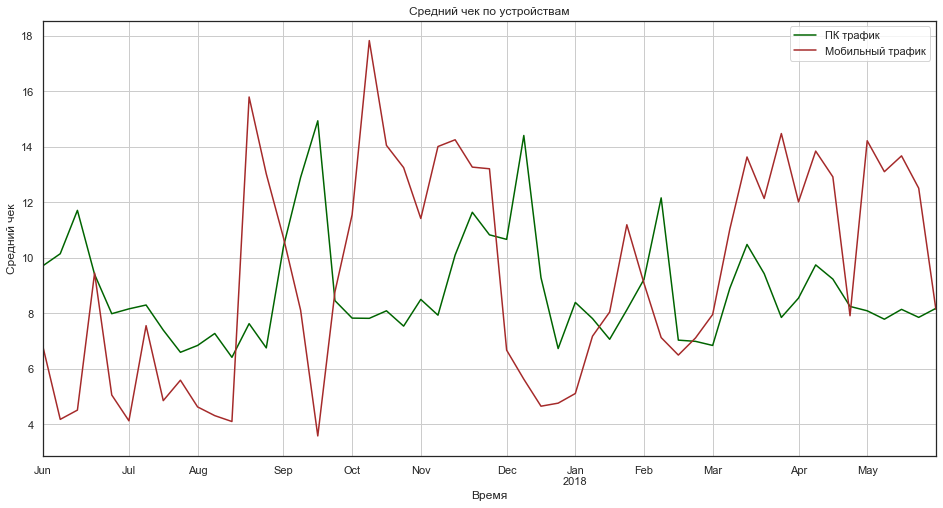

In [97]:
orders_by_device = (visits_and_orders
                      .groupby(['week', 'device'])
                      .agg({'revenue':'sum','buy_ts':'count'})
                      .reset_index()
                    )
orders_by_device['average_bill'] = orders_by_device['revenue'] / orders_by_device['buy_ts']

(orders_by_device
    .groupby(['week', 'device'])
    .agg({'average_bill':'max'}) # декоративная функция - ничего не делает (можно вписать любую), но позваляет создть график
    .reset_index()
    .pivot_table(index='week', columns='device', values='average_bill', aggfunc='max')
    .plot(title='Средний чек по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Средний чек')
plt.xlabel('Время')
plt.show()

Десктопный трафик приводит более менее стабильные средние чеки, а мобильный сильно "прыгает", но в целом средний чек оттуда растёт.

In [98]:
orders_by_source = (visits_and_orders
                                  .groupby('source_id')
                                  .agg({'revenue':'sum','buy_ts':'count'})
                                  .reset_index()
                                 )
orders_by_source['average_bill'] = orders_by_source['revenue'] / orders_by_source['buy_ts']

orders_by_source_and_device = (visits_and_orders
                                  .groupby(['source_id','device'])
                                  .agg({'revenue':'sum','buy_ts':'count'})
                                  .reset_index()
                                 )
orders_by_source_and_device['average_bill'] = orders_by_source_and_device['revenue'] / orders_by_source_and_device['buy_ts']

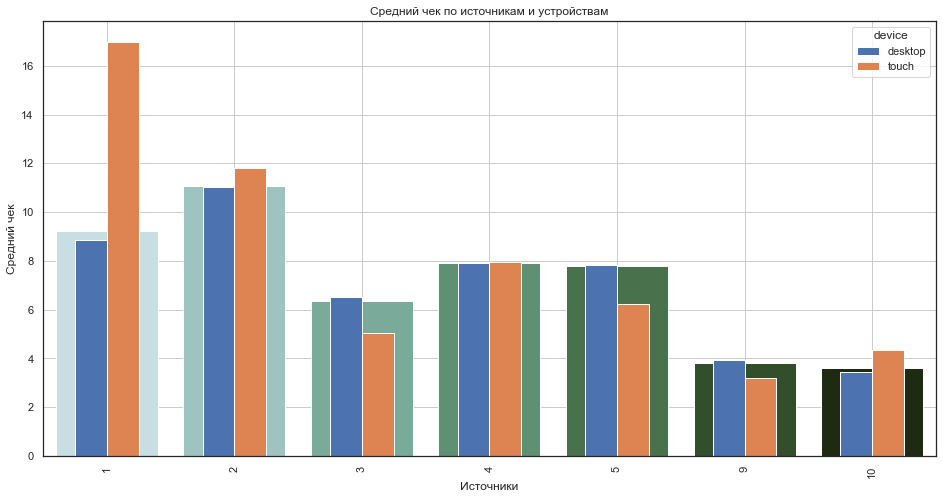

In [99]:
source_df = (orders_by_source
             .query('(source_id != 6) and (source_id != 7)')
             .groupby('source_id') #[['source_id','average_bill']]
             .agg({'average_bill':'max'}) # декоративная функция - ничего не делает (можно вписать любую), но позваляет создть график
             .reset_index()
            )
source_and_device_df = (orders_by_source_and_device
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device']) #[['source_id','device','average_bill']]
                        .agg({'average_bill':'max'}) # декоративная функция - ничего не делает (можно вписать любую), но позваляет создть график
                        .reset_index()
                       )

plt.title('Средний чек по источникам и устройствам')
ax = sns.barplot(x='source_id', y='average_bill',  palette="ch:1.5", data=source_df)

(source_and_device_df
         .pivot_table(index='source_id', columns='device', values='average_bill')
         .plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)
)

plt.ylabel('Средний чек')
plt.xlabel('Источники')
plt.show()

Здесь видно как средний чек по 1 источнику намного выше у мобильных устройств. И вообще - это первый график на котором мобильный и ПК трафик различается от источника к источнику. Наиболее хорошим можно назвать 2 источник - оттуда идут хорошие и ПК и мобильные средние чеки.

In [100]:
print(f"Ну а средний чек за всё время = {round((orders_by_cohorts['average_bill'].mean()),2)}")

Ну а средний чек за всё время = 7.65


In [101]:
orders_by_source.groupby('source_id')['average_bill'].mean()

source_id
1      9.242265
2     11.071013
3      6.344095
4      7.923842
5      7.781887
7      1.220000
9      3.806667
10     3.630303
Name: average_bill, dtype: float64

In [102]:
orders_by_cohorts.groupby('first_buy_month')['average_bill'].mean()

first_buy_month
2017-06     6.853978
2017-07     6.252011
2017-08     6.513505
2017-09    17.285688
2017-10     5.119685
2017-11     4.571543
2017-12    14.092359
2018-01     4.963399
2018-02     3.900908
2018-03     5.482008
2018-04     5.226746
2018-05     4.286168
2018-06     3.420000
Name: average_bill, dtype: float64

---

<h3 align='center'><font color="#173b3f"> Сколько денег приносят? (LTV) </font></h3><br>

Для того, чтобы узгать LTV в датасете не хватает только столбца с валовой прибылью. Т.к. нам не известна доходность сайта (маржа), предлагаю взять максимально близкое к правде число 50%. Почему 50% максимально близкое? Потому что 100% - это безубыточный бизнес, что не возможно, а за 0% прибыли никто бы не стал содержать бизнес столько лет, соответственно при 50% предпологаемой маржинальности, можно ошибиться максимум на 49,9%

In [103]:
margin_rate = 0.5
orders_by_cohorts['profit'] = orders_by_cohorts['revenue_sum'] * margin_rate
orders_by_cohorts['ltv'] = orders_by_cohorts['profit'] / orders_by_cohorts['uid_count']
orders_by_cohorts.head()

first_buy_month  buy_month  revenue_sum  buy_count  uid_count  cohort_month  \
0         2017-06 2017-06-01      9557.49       2354       2023             0   
1         2017-06 2017-07-01       981.82        177         61             1   
2         2017-06 2017-08-01       885.34        174         50             2   
3         2017-06 2017-09-01      1931.30        226         54             3   
4         2017-06 2017-10-01      2068.58        292         88             4   

   average_bill    profit        ltv  
0      4.060106  4778.745   2.362207  
1      5.547006   490.910   8.047705  
2      5.088161   442.670   8.853400  
3      8.545575   965.650  17.882407  
4      7.084178  1034.290  11.753295

In [104]:
print(f"Средний LTV за всё исследуемое время: {round(orders_by_cohorts['ltv'].mean(), 2)} у.е.")

Средний LTV за всё исследуемое время: 7.37 у.е.


In [105]:
ltv_by_cohorts = (orders_by_cohorts
     .query('first_buy_month < "2018-06"') # 2018-06 - этот месяц не полный, там всего 1 покупка
     .pivot_table(index='first_buy_month', columns='cohort_month', values='ltv', aggfunc='mean')
     .cumsum(axis=1)
     .round(2)
)

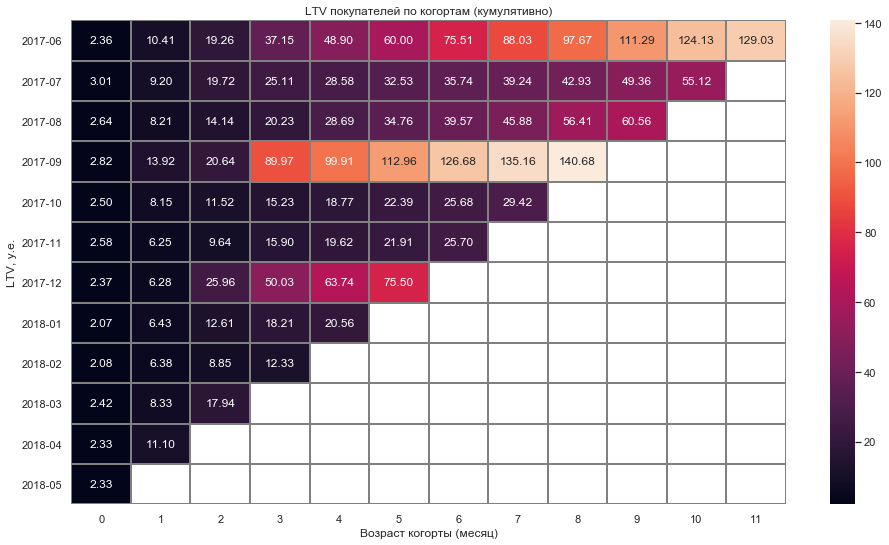

In [106]:
plt.figure(figsize=(16, 8.9))
plt.title('LTV покупателей по когортам (кумулятивно)')
sns.heatmap(ltv_by_cohorts, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

plt.ylabel('LTV, у.е.')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

Видно как у каждой 3 когорты, на 3 месяц возникает желание потратить больше денег, возможно это дает плоды маркетинговая кампания (о которой я не знаю) или это ещё связано с премьерами, вполне возможно, что они запускаются каждый третий месяц. 

Ситуация повторяется и на 6 месяц, но менее ярко. А вот когорты октября и ноября дают низкий LTV, стоит придумать для них рекламную кампанию, ведь покупателей, как мы помним из предыдущих отчётов, там много.

---

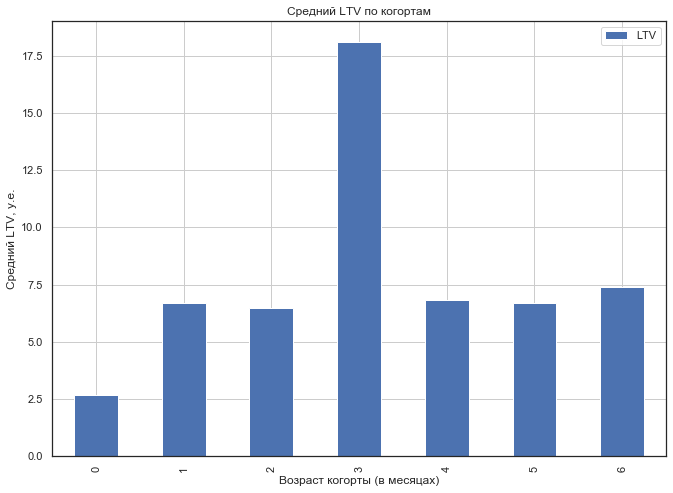

In [107]:
(orders_by_cohorts
 .query('(cohort_month <= 6) and (first_buy_month <= "2017-11")')
 .groupby('cohort_month')
 .agg({'ltv':'mean'})
 .reset_index()
 .plot.bar(x='cohort_month', y='ltv', title='Средний LTV по когортам', grid=True, figsize=(11,8))
)

plt.legend(['LTV'])
plt.ylabel('Средний LTV, у.е.')
plt.xlabel('Возраст когорты (в месяцах)')
plt.show()

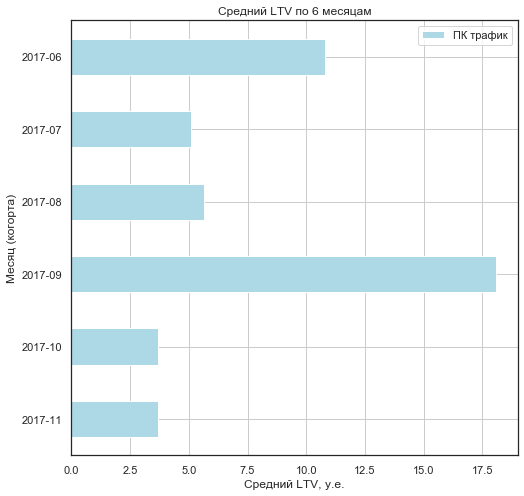

In [108]:
(orders_by_cohorts
      .query('(cohort_month <= 6) and (first_buy_month <= "2017-11")')
     .groupby('first_buy_month')
     .agg({'ltv':'mean'})
     .sort_values(by='first_buy_month', ascending=False)
     .reset_index()
     .plot.barh(x='first_buy_month', y='ltv', title='Средний LTV по 6 месяцам', grid=True, figsize=(8,8), color='lightblue')
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Месяц (когорта)')
plt.xlabel('Средний LTV, у.е.')
plt.show()

С помоью этих графиков можно увидеть на сколько определенные месяцы и когорты дают больше отдачи (ltv) по отношению к другим. Сразу видно яркий 3 месяц возрата когорты и ключевые когорты: июнь, сентябрь.

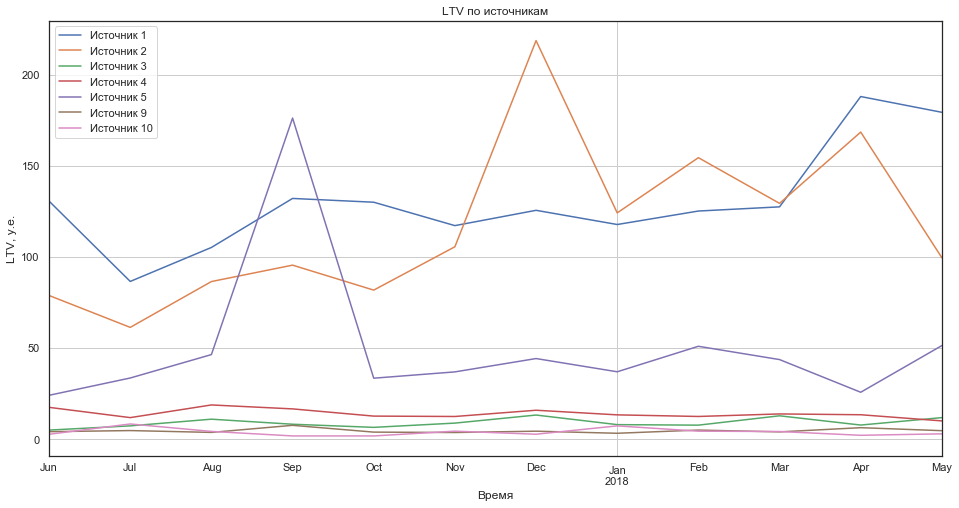

In [109]:
ltv_by_source = (visits_and_orders
                    .groupby(['month','source_id'])
                    .agg({'revenue':'sum','uid':'nunique'})
                    .reset_index()
                )
ltv_by_source['profit'] = ltv_by_source['revenue'] * margin_rate
ltv_by_source['ltv'] = ltv_by_source['profit'] / ltv_by_source['uid']

(ltv_by_source
    .query('(source_id != 6) and (source_id != 7)')
    .groupby(['source_id','month'])['ltv']
    .mean()
    .reset_index()
    .pivot_table(index='month', columns='source_id', values='ltv', aggfunc='mean')
    .plot(title='LTV по источникам', grid=True)
)
plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('LTV, у.е.')
plt.xlabel('Время')
plt.show()

1 и 2 источники дают покупателей с наибольшим LTV. У 5 источника был всплеск в сентябре. Возможно по нему активно рекламировалась премьера нового события, да и потом сентябрьская когорта показывала хороший LTV.

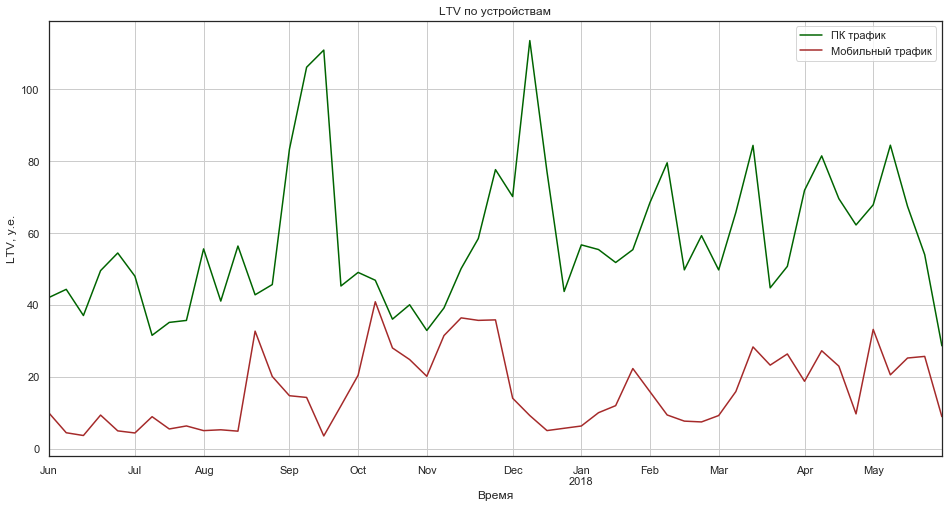

In [110]:
ltv_by_device = (visits_and_orders
                    .groupby(['week','device'])
                    .agg({'revenue':'sum','uid':'nunique'})
                    .reset_index()
                )
ltv_by_device['profit'] = ltv_by_device['revenue'] * margin_rate
ltv_by_device['ltv'] = ltv_by_device['profit'] / ltv_by_device['uid']

(ltv_by_device
    .groupby(['week','device'])['ltv']
    .mean()
    .reset_index()
    .pivot_table(index='week', columns='device', values='ltv', aggfunc='mean')
    .plot(title='LTV по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('LTV, у.е.')
plt.xlabel('Время')
plt.show()


Дестктоп опять лидирует, LTV по нему выше во все времена. Мобильный LTV лишь в ноябре приблизились к ПК, ито благодяря просадке у ПК.

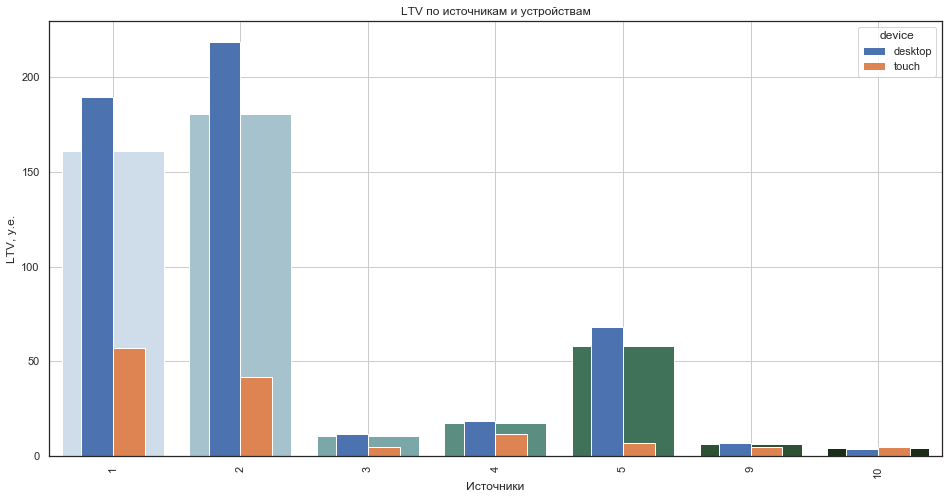

In [111]:
ltv_by_source_and_device = (visits_and_orders
                            .groupby(['source_id','device'])
                            .agg({'revenue':'sum','uid':'nunique'})
                            .reset_index()
                            )
ltv_by_source_and_device['profit'] = ltv_by_source_and_device['revenue'] * margin_rate
ltv_by_source_and_device['ltv'] = ltv_by_source_and_device['profit'] / ltv_by_source_and_device['uid']

ltv_by_source = (visits_and_orders
                            .groupby('source_id')
                            .agg({'revenue':'sum','uid':'nunique'})
                            .reset_index()
                            )
ltv_by_source['profit'] = ltv_by_source['revenue'] * margin_rate
ltv_by_source['ltv'] = ltv_by_source['profit'] / ltv_by_source['uid']

source_df = (ltv_by_source
             .query('(source_id != 6) and (source_id != 7)')
             .groupby('source_id')
             .agg({'ltv':'max'}) # декоративная ф-я
             .reset_index()
            )
source_and_device_df = (ltv_by_source_and_device
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'ltv':'max'}) # декоративная ф-я
                        .reset_index()
                       )

plt.title('LTV по источникам и устройствам')
ax = sns.barplot(x='source_id', y='ltv',  palette="ch:1.7", data=source_df)

(source_and_device_df
         .pivot_table(index='source_id', columns='device', values='ltv', aggfunc='max') # декоративная ф-я
         .plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)
)

plt.ylabel('LTV, у.е.')
plt.xlabel('Источники')
plt.show()

1 и 2 источники и ПК - вот откуда идут наиболее легко тратящие покупатели, на них стоит повышать бюджеты. Мобильный LTV лишь чуть-чуть превышает ПК в 10 источнике, но в целом там показатель самый низкий.

Напомню, что средний LTV за всё исследуемое время: 7.37 у.е. - столько приносит пользователь в среднем в месяц

---

<h3 align='center'><font color="#173b3f"> Сколько денег потратили? Всего / на каждый источник / по времени </font></h3><br>

In [112]:
print(f"Всего потрачено за всё исследуемое время: {costs_log['costs'].sum()} у.е.")

Всего потрачено за всё исследуемое время: 329131.62 у.е.


In [113]:
costs_by_source = costs_log.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49

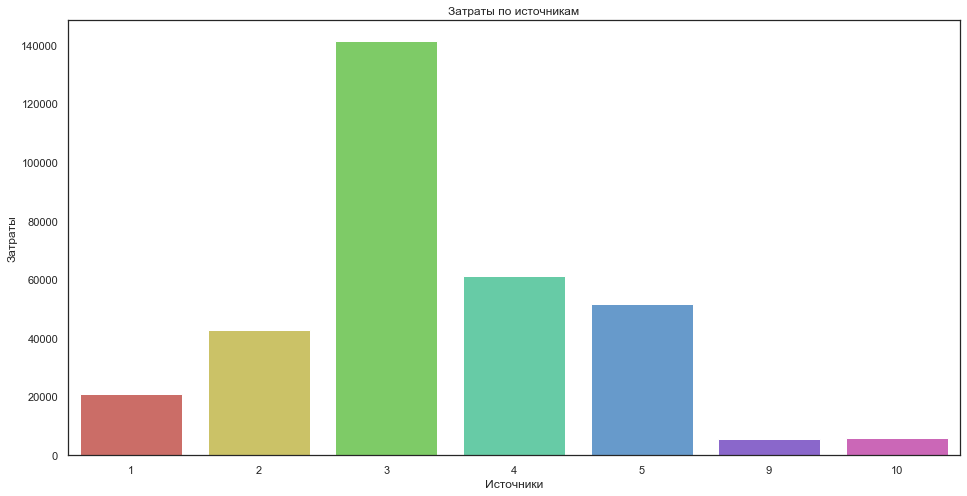

In [114]:
sns.barplot(x='source_id', y='costs', palette="hls", data=costs_by_source)
plt.title('Затраты по источникам')

plt.ylabel('Затраты')
plt.xlabel('Источники')
plt.show()

На 3 источник потрачено гораздо больше средств, чем на остальные. Интересно, целесообразно ли? Узнаем далее.

---

In [115]:
costs_log['week'] = costs_log['dt'].astype('datetime64[W]')
costs_log['month'] = costs_log['dt'].astype('datetime64[M]')
costs_log['month'] = costs_log['month'].dt.strftime('%Y-%m')

In [116]:
costs_by_month = costs_log.groupby('month')['costs'].sum().reset_index()
costs_by_month

month     costs
0   2017-06  18015.00
1   2017-07  18240.59
2   2017-08  14790.54
3   2017-09  24368.91
4   2017-10  36322.88
5   2017-11  37907.88
6   2017-12  38315.35
7   2018-01  33518.52
8   2018-02  32723.03
9   2018-03  30415.27
10  2018-04  22289.38
11  2018-05  22224.27

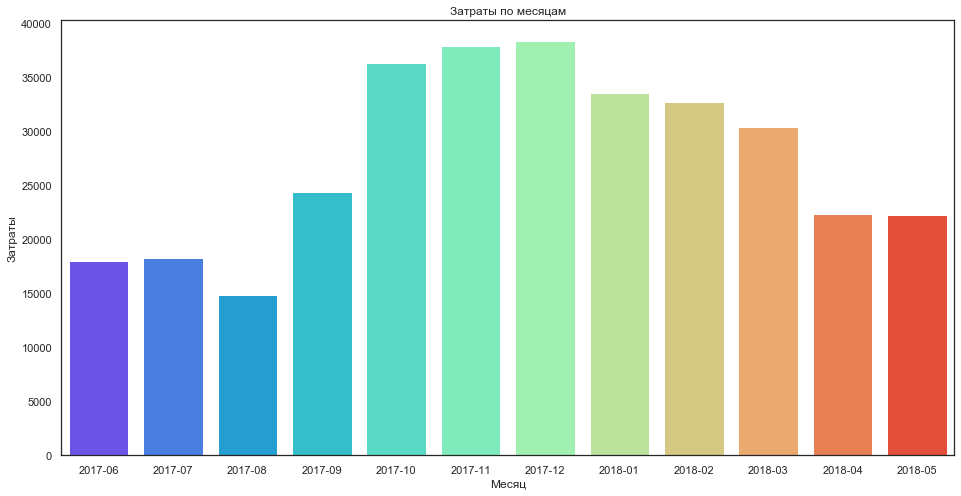

In [117]:
sns.barplot(x='month', y='costs', palette="rainbow", data=costs_by_month)
plt.title('Затраты по месяцам')
plt.ylabel('Затраты')
plt.xlabel('Месяц')
plt.show()

На протяжении года наибольшие средства были потрачены в холодные месяцы, не удивительно, что трафика на сайте в эти месяцы больше. Т.е. это не только потому, что все вернулись с отпусков и заходят с работы, как я писал ранее. Я думаю, можно даже сравнить трафик и расходы:

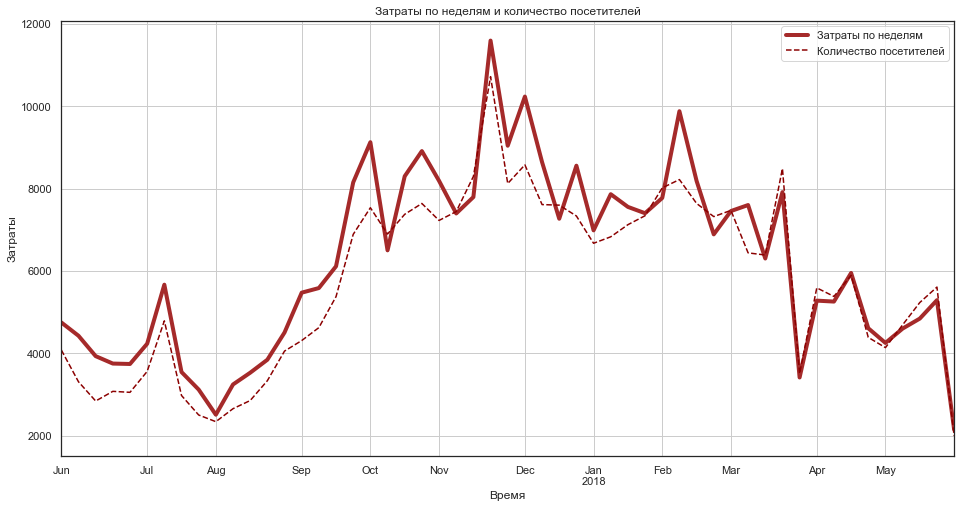

In [118]:
ax =(costs_log
    .groupby('week')['costs'].sum()
    .reset_index()
    .plot(x='week', y='costs', title='Затраты по неделям и количество посетителей', grid=True, figsize=(16,8), color='brown', linewidth=4)
)
visits_log_weekly.plot(ax=ax,  grid=True, figsize=(16, 8), style='--', color='darkred')

plt.legend(['Затраты по неделям','Количество посетителей'])
plt.ylabel('Затраты')
plt.xlabel('Время')
plt.show()

Вот здесь видно как трафик и расходы коррелируют, практически в точности повторяя друг друга. Выходит почти весь успех - это маркетинг и реклама. Здорово ;)

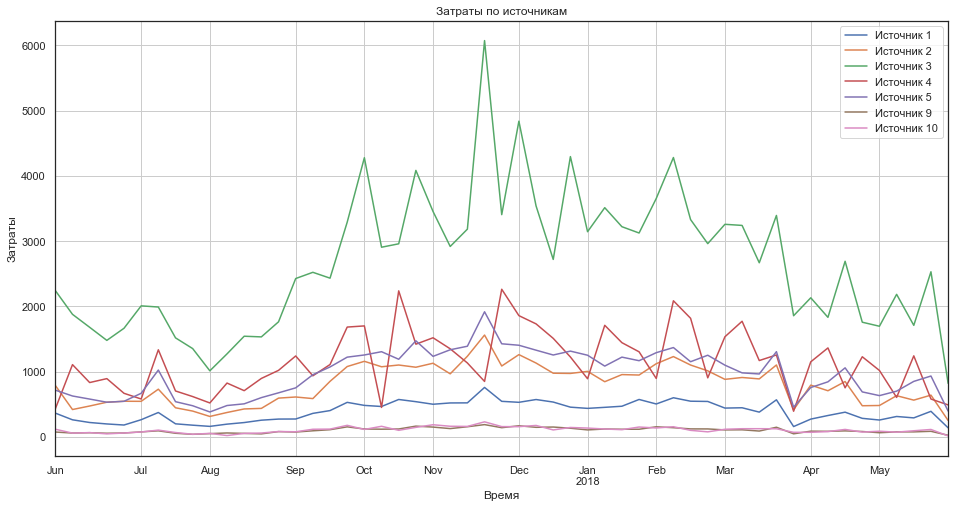

In [119]:
(costs_log
    .query('(source_id != 6) and (source_id != 7)')
    .groupby(['week','source_id'])['costs']
    .sum()
     .reset_index()
    .pivot_table(index='week', columns='source_id', values='costs', aggfunc='sum')
    .plot(title='Затраты по источникам', grid=True)
)

plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('Затраты')
plt.xlabel('Время')
plt.show()

3 источник был самым затратным на протяжении всего года, не помню, чтоб по нему было много трафика или продаж, стоит пересмотреть бюджет и перераспередлить на более выгодные, а на какие узнаем далее

In [120]:
visits_log['month'] = visits_log['month'].dt.strftime('%Y-%m')
costs_log = costs_log.rename(columns = {'dt':'day'})

In [121]:
visits_and_costs = visits_log.merge(costs_log, on=['source_id','day','week','month'])
visits_and_costs.tail()

device              end_ts  source_id            start_ts  \
359350  desktop 2017-07-08 13:50:00         10 2017-07-08 13:35:00   
359351    touch 2017-06-25 19:26:00          9 2017-06-25 19:22:00   
359352  desktop 2017-06-25 23:07:00          9 2017-06-25 23:06:00   
359353  desktop 2017-07-08 21:19:00          9 2017-07-08 21:15:00   
359354  desktop 2017-07-08 17:59:00          9 2017-07-08 17:56:00   

                         uid        day       week    month  duration_ts  \
359350   5924018940076097751 2017-07-08 2017-07-06  2017-07        900.0   
359351  10296792356042352601 2017-06-25 2017-06-22  2017-06        240.0   
359352   9129220959111736770 2017-06-25 2017-06-22  2017-06         60.0   
359353   8938068022739009704 2017-07-08 2017-07-06  2017-07        240.0   
359354    985933245783267349 2017-07-08 2017-07-06  2017-07        180.0   

             first_session first_session_month  costs  
359350 2017-07-08 13:35:00          2017-07-01   3.89  
359351 2017-06-25 19:22:00          2017-06-01   8.84  
359352 2017-06-25 23:06:00          2017-06-01   8.84  
359353 2017-07-08 21:15:00          2017-07-01   8.11  
359354 2017-07-08 17:56:00          2017-07-01   8.11

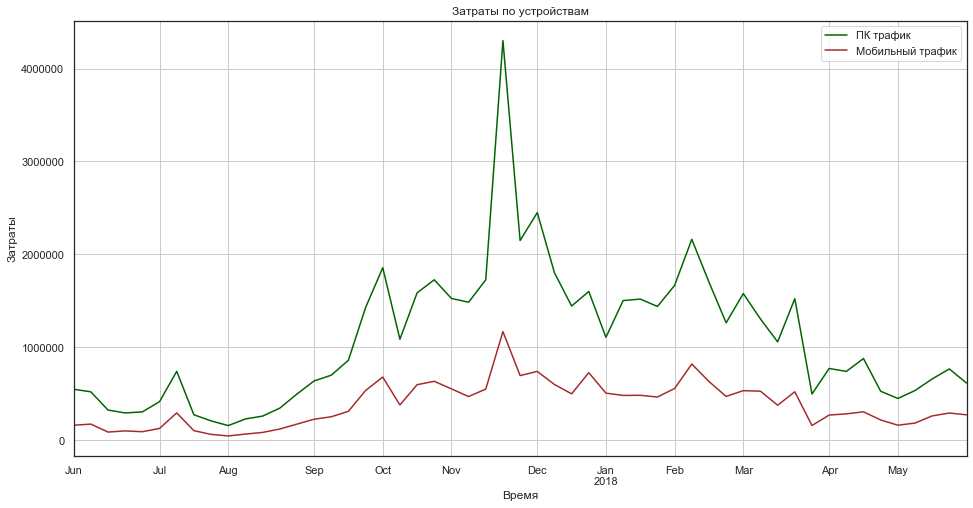

In [122]:
(visits_and_costs
    .query('(source_id != 6) and (source_id != 7)')
    .groupby(['device','week'])['costs']
    .sum()
    .reset_index()
    .pivot_table(index='week', columns='device', values='costs', aggfunc='sum')
    .plot(title='Затраты по устройствам', grid=True, color=['darkgreen','brown'])
)

plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('Затраты')
plt.xlabel('Время')
plt.show()

На ПК больше затрат на протяжении всего года, что вполне логично, ведь оттуда и средние чеки больше, и покупают чаще

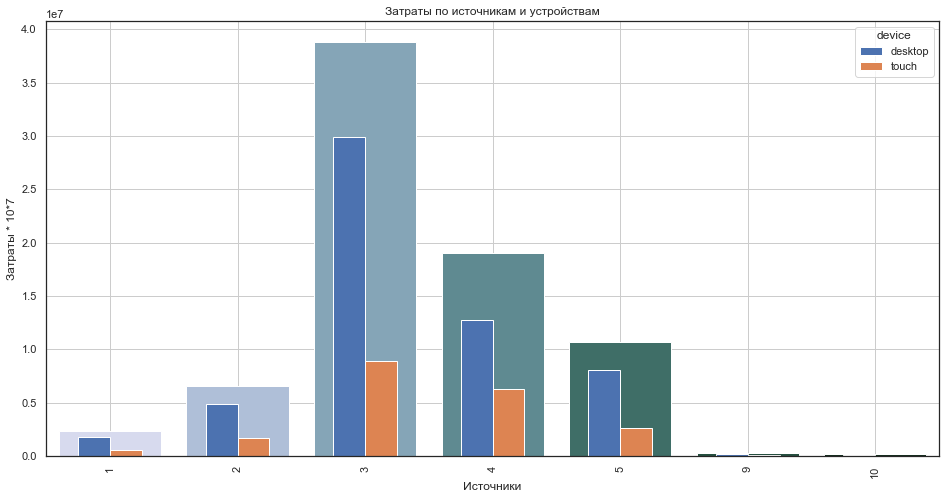

In [123]:
source_df = (visits_and_costs
             .query('(source_id != 6) and (source_id != 7)')
             .groupby(['source_id'])
             .agg({'uid':'nunique','costs':'sum'})
             .reset_index()
            )

source_and_device_df = (visits_and_costs
                        .query('(source_id != 6) and (source_id != 7)')
                        .groupby(['source_id','device'])
                        .agg({'uid':'nunique','costs':'sum'})
                        .reset_index()
                       )

ax = sns.barplot(x='source_id', y='costs',  palette="ch:1.9", data=source_df)

(source_and_device_df
         .pivot_table(index='source_id', columns='device', values='costs', aggfunc='sum')
         .plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)
)

plt.title('Затраты по источникам и устройствам')
plt.ylabel('Затраты * 10*7')
plt.xlabel('Источники')
plt.show()

На 3 источник тратится намного больше денег, чем на другие, при этом трафик (как мы поним) с этого источника не сопоставимо выше, а находится на уровне 4 источника, на который потрачено в 2 раза меньше. Далее рассмотрим, окупаются ли эти затраты, или всё таки стоит пересмотреть бюджет.

---

<h3 align='center'><font color="#173b3f"> Сколько стоило привлечение одного покупателя из каждого источника? </font></h3><br>

In [124]:
print(f"Итак, средняя стоимость привлечения клиента = {(costs_log['costs'].sum() / orders_log['uid'].nunique()).round(4)} у.е.")

Итак, средняя стоимость привлечения клиента = 9.0116 у.е.


Далее нам нужна таблица в которой будет число только абсолютно уникальных покупателей за каждый день и сколько было потрачено в день их первого визита. Т.е. нам нужны UIDы всех покупателей, отсеять visits_log по ним, а потом сопоставить дни первого визита и дни затрат + сами затраты.

In [125]:
unique_buyers = orders_log['uid'].unique() # список уникальных ID покупателей
visits_of_buyers = visits_log.query('uid in @unique_buyers').reset_index(drop=True) # остались визиты только покупателей
visits_of_buyers = visits_of_buyers.drop_duplicates(subset='uid') # удалили повторные покупки, остались только первые покупки всех покупателей
visits_of_buyers['first_session_day'] = visits_of_buyers['first_session'].astype('datetime64[D]') # взяли день из даты первого визита
source_of_buyers = visits_of_buyers.groupby(['first_session_day','source_id']).agg({'uid':'nunique'}).reset_index() # сагрегировали количество уников по дню и источнику
source_of_buyers.head()

first_session_day  source_id  uid
0        2017-06-01          1   25
1        2017-06-01          2   35
2        2017-06-01          3   39
3        2017-06-01          4   30
4        2017-06-01          5   26

Дальше можем совместить эту таблицу с затратами и посчитать стоимость каждого покупателя по источнику

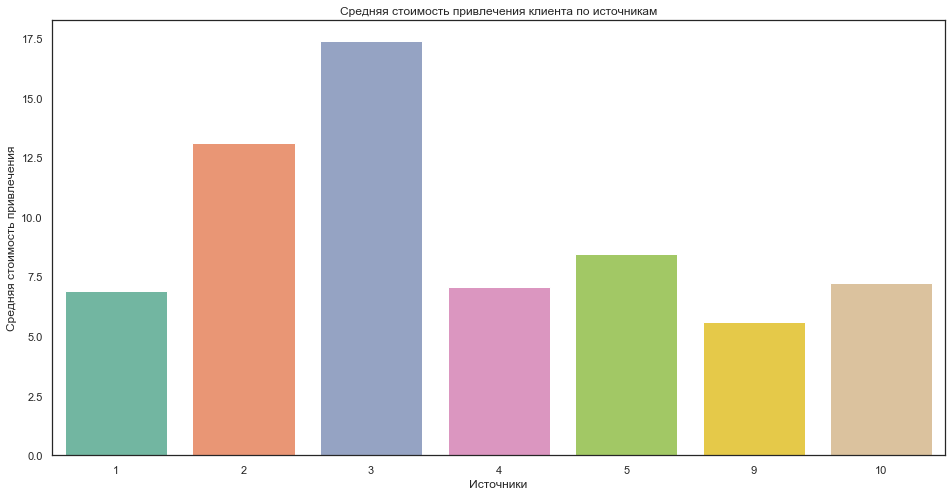

In [126]:
cac_by_source = source_of_buyers.merge(costs_log, left_on=['first_session_day','source_id'], right_on=['day','source_id'])
cac_by_source['cac'] = (cac_by_source['costs'] / cac_by_source['uid']).round(2)
cac_by_source_grouped = cac_by_source.groupby('source_id').mean().reset_index()

sns.barplot(x='source_id', y='cac', palette="Set2", data=cac_by_source_grouped)
plt.title('Средняя стоимость привлечения клиента по источникам')
plt.ylabel('Средняя стоимость привлечения')
plt.xlabel('Источники')
plt.show()

Наиболее дорогими обходятся клиенты с 3 источника, а самые дешевые с 9-го. Так же к дешевым можно отнести 1,4 и 10 источники. Как маркетолог, могу с большой уверенностью сказать, что 3 источник это медийная реклама, обычно она играет на раскрутку бренда и узнаваемость, а не генерирует трафик и продажи.

---

Дальше я попытался посчитать стоимость затрат по устройствам, но т.к. такой колонки нет в таблице с затратами, что бы я не делал, ничего не выходило, например вот такая таблица, в которой я высчитал процент покупателей внутри дня по устройствам, потом этот процент применил к затратам и думал получить разный CAC, но потом понял, что так не получится, CAC будет одинаковым для обоих устройств:

In [127]:
# оставляем нужные столбцы и аггрегируем данные по ним 
device_of_buyers = (visits_of_buyers
                    .groupby(['first_session_day','device'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                   )

# объединяем количество ПК и мобильных покупателей
sum_uids = device_of_buyers.groupby('first_session_day')['uid'].sum().reset_index()
sum_uids = sum_uids.rename(columns = {'uid':'sum_uids'})

# объединяем
device_of_buyers = device_of_buyers.merge(sum_uids, on='first_session_day')

# процентные соотношения ко всем устройствам
device_of_buyers['percent_of_all_device'] = (device_of_buyers['uid'] / device_of_buyers['sum_uids'])

# оставляем затраты по дням в costs_log и объединяем
costs_prepare = costs_log.groupby('day')['costs'].sum().reset_index()
device_of_buyers_and_costs = device_of_buyers.merge(costs_prepare, left_on='first_session_day', right_on='day')

# создаем дополнительные столбцы
device_of_buyers_and_costs['costs_by_device'] = (device_of_buyers_and_costs['costs'] * device_of_buyers_and_costs['percent_of_all_device']).round(2)
device_of_buyers_and_costs['cac_by_device'] = (device_of_buyers_and_costs['costs_by_device'] / device_of_buyers_and_costs['uid']).round(2)
device_of_buyers_and_costs.head()

first_session_day   device  uid  sum_uids  percent_of_all_device        day  \
0        2017-06-01  desktop  139       170               0.817647 2017-06-01   
1        2017-06-01    touch   31       170               0.182353 2017-06-01   
2        2017-06-02  desktop  121       148               0.817568 2017-06-02   
3        2017-06-02    touch   27       148               0.182432 2017-06-02   
4        2017-06-03  desktop   70        90               0.777778 2017-06-03   

    costs  costs_by_device  cac_by_device  
0  735.26           601.18           4.33  
1  735.26           134.08           4.33  
2  721.19           589.62           4.87  
3  721.19           131.57           4.87  
4  450.85           350.66           5.01

Как видим уже по первым строкам, попытка неудачная, двигаемся дальше

---

Посмотрим как CAC изменялся с течением времени, по неделям:

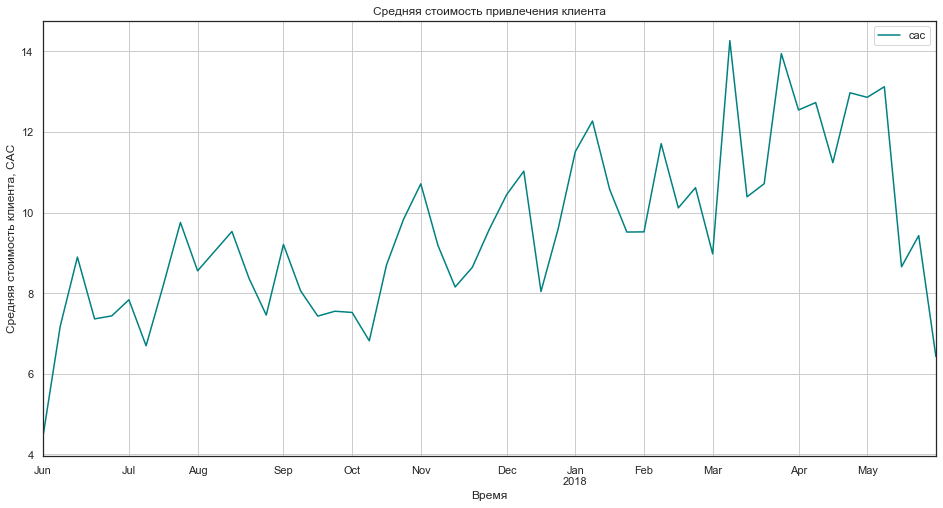

In [128]:
buyers_by_days = visits_of_buyers.groupby(['first_session_day']).agg({'uid':'nunique'}).reset_index()
cac_by_days = buyers_by_days.merge(costs_prepare, left_on=['first_session_day'], right_on=['day'])
cac_by_days = cac_by_days.drop(columns='day', axis=1)
cac_by_days['cac'] = (cac_by_days['costs'] / cac_by_days['uid']).round(2)
cac_by_days['first_session_week'] = cac_by_days['first_session_day'].astype('datetime64[W]')
cac_by_week = cac_by_days.groupby('first_session_week')['cac'].mean().reset_index()
cac_by_week.plot(x='first_session_week', y='cac', grid=True, color='teal')

plt.title('Средняя стоимость привлечения клиента')
plt.ylabel('Средняя стоимость клиента, CAC')
plt.xlabel('Время')
plt.show()

Посмотрим ещё по месяцам, в виде таблицы:

In [129]:
cac_by_days['first_session_month'] = cac_by_days['first_session_day'].astype('datetime64[M]')
cac_by_days['first_session_month'] = cac_by_days['first_session_month'].dt.strftime('%Y-%m')
cac_by_month = cac_by_days.groupby('first_session_month')['cac'].mean().reset_index()
cac_by_month

first_session_month        cac
0              2017-06   6.972667
1              2017-07   7.965806
2              2017-08   8.845161
3              2017-09   8.108333
4              2017-10   8.010323
5              2017-11   9.255333
6              2017-12   9.518065
7              2018-01  11.014516
8              2018-02  10.492143
9              2018-03  11.507667
10             2018-04  11.967931
11             2018-05  11.267097

Как видно стоимость закупки клиентов растёт с течением времени. Видимо борьба за внимание каждого пользователя растёт, вместе с ценой. Очень важно тратить эти деньги на более лояльных пользователей, на каких? прочитаете в общем выводе, после исследования ROI

---

<h3 align='center'><font color="#173b3f"> На сколько окупились расходы? (ROI) </font></h3><br>

Сначала построим график ROI по дням, причём привяжем покупателей не к дням их первой покупки, а дням первого визита, ведь именно тогда на них были потрачены деньги на привлечение, соответственно к этим дням и нужно привязывать расходы на них

In [130]:
# удалим визиты без продаж
visits_by_buyers = visits_and_orders.drop_duplicates(subset=['uid','buy_ts'])

# сгруппируем таблицу и оставим только нужные столбцы с аггрегированными показателями
visits_by_buyers = (visits_by_buyers
                    .groupby(['first_session','uid'])
                    .agg({'revenue':'sum'})
                    .reset_index()
                   )
visits_by_buyers.head()

first_session                   uid  revenue
0 2017-06-01 00:09:00  10329302124590727494    17.00
1 2017-06-01 00:14:00  11627257723692907447     0.55
2 2017-06-01 00:14:00  16109239769442553005     0.55
3 2017-06-01 00:25:00  17903680561304213844     0.37
4 2017-06-01 01:18:00  16945437833757229838     1.67

Проверим не потеряли ли мы доход при скрещивании таблиц и других опирациях:

In [131]:
print(f"Суммарный доход в новой таблице visits_by_buyers = {visits_by_buyers['revenue'].sum()}, а суммарный доход в исходной, orders_log = {orders_log['revenue'].sum().round(1)}, всё хорошо")

Суммарный доход в новой таблице visits_by_buyers = 252057.2, а суммарный доход в исходной, orders_log = 252057.2, всё хорошо


Теперь привяжем расходы:

In [132]:
visits_by_buyers['first_session_day'] = visits_by_buyers['first_session'].astype('datetime64[D]')

#объединяем с таблицей по затратам
main_df = visits_by_buyers.merge(costs_prepare, left_on='first_session_day', right_on='day')
main_df = main_df.drop(columns='day', axis=1)
main_df

first_session                   uid  revenue first_session_day  \
0     2017-06-01 00:09:00  10329302124590727494    17.00        2017-06-01   
1     2017-06-01 00:14:00  11627257723692907447     0.55        2017-06-01   
2     2017-06-01 00:14:00  16109239769442553005     0.55        2017-06-01   
3     2017-06-01 00:25:00  17903680561304213844     0.37        2017-06-01   
4     2017-06-01 01:18:00  16945437833757229838     1.67        2017-06-01   
...                   ...                   ...      ...               ...   
36518 2018-05-31 23:26:00  15854392578508828030     0.92        2018-05-31   
36519 2018-05-31 23:31:00   1551265230644458155     0.61        2018-05-31   
36520 2018-05-31 23:35:00  15576344609395725707     2.26        2018-05-31   
36521 2018-05-31 23:52:00   1786462140797698849     0.30        2018-05-31   
36522 2018-05-31 23:59:00     83872787173869366     3.42        2018-05-31   

         costs  
0       735.26  
1       735.26  
2       735.26  
3       735.26  
4       735.26  
...        ...  
36518  2153.70  
36519  2153.70  
36520  2153.70  
36521  2153.70  
36522  2153.70  

[36523 rows x 5 columns]

Посчитаем LTV, CAC и ROI внутри каждого дня:

In [133]:
# создаем аггрегированную таблицу, оставим только нужные столбцы
roi = (main_df
       .groupby(['first_session_day', 'costs'])
       .agg({'uid':'nunique','revenue':'sum'})
       .reset_index()
      )

# добавляем необходимые показатели для подсчёта roi
roi['profit'] = (roi['revenue'] * margin_rate).round(2)
roi['ltv'] = (roi['profit'] / roi['uid']).round(2)
roi['cac'] = (roi['costs'] / roi['uid']).round(2)
roi['roi'] = (roi['ltv'] / roi['cac'] *100).round(2) # можно ещё посчитать так: (roi['profit']/roi['costs']).round(2) - те же самые цифры
roi.head()

first_session_day   costs  uid  revenue   profit    ltv   cac     roi
0        2017-06-01  735.26  170  8099.34  4049.67  23.82  4.33  550.12
1        2017-06-02  721.19  148  1583.92   791.96   5.35  4.87  109.86
2        2017-06-03  450.85   90  1430.39   715.19   7.95  5.01  158.68
3        2017-06-04  761.16  106  5286.34  2643.17  24.94  7.18  347.35
4        2017-06-05  821.44  222  4876.77  2438.39  10.98  3.70  296.76

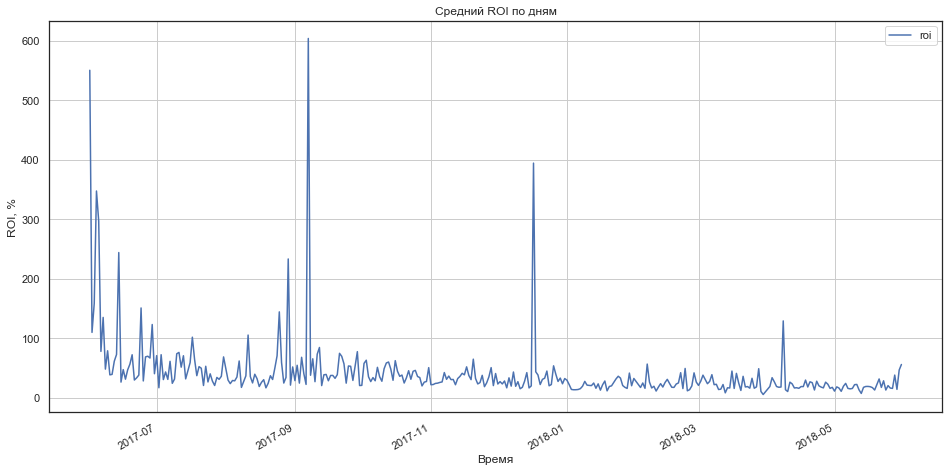

In [134]:
# создаем график
roi.plot(x='first_session_day', y='roi', grid=True)
plt.title('Средний ROI по дням')
plt.ylabel('ROI, %')
plt.xlabel('Время')
plt.show()

Этот график интересен тем, что он показывает на сколько выгодными оказались люди, на которых в день их первого посещения потратили деньги. Т.е., например, за 1 день пришло 10 человек за 100 у.е. затрат, потом они в течение года приносили деньги и отбивали эти 100 у.е. и теперь мы видим как они окупились (или нет) на графике в рамках своих дней

На графике видны пики, видимо в эти дни были преведены особо расточительные люди, которые в течение последующих месяцев тратили достаточно много денег и окупили себя в несколько раз, самый большой пик - в 6 раз

---

Теперь создадим такую же табоицу, но по месяцам, чтобы посмотреть на общую картину

In [135]:
# удалим визиты без продаж
orders_log_clear = orders_log.drop_duplicates(subset=['uid','buy_ts'])

# создаем аггрегированную таблицу, оставим только нужные столбцы
orders_log_clear = (orders_log_clear
                    .groupby(['first_buy_month'])
                    .agg({'uid':'nunique','revenue':'sum'})
                    .reset_index()
                   )
orders_log_clear['first_buy_month'] = orders_log_clear['first_buy_month'].dt.strftime('%Y-%m') #для красоты

# создаем аггрегированную таблицу затрат по месяцам
costs_by_month = costs_log.groupby('month')['costs'].sum()

# объединяем с продажами
orders_and_costs = orders_log_clear.merge(costs_by_month, left_on='first_buy_month', right_on='month')

# сгруппируем таблицу и оставим только нужные столбцы с аггрегированными показателями
roi_by_month = (orders_and_costs
                .groupby(['first_buy_month'])
                .agg({'uid':'sum','revenue':'sum','costs':'sum'})
                .reset_index()
               )

# добавляем необходимые показатели для подсчёта roi
roi_by_month['profit'] = (roi_by_month['revenue'] * margin_rate).round(2)
roi_by_month['ltv'] = (roi_by_month['profit'] / roi_by_month['uid']).round(2)
roi_by_month['cac'] = (roi_by_month['costs'] / roi_by_month['uid']).round(2)
roi_by_month['roi'] = (roi_by_month['ltv'] / roi_by_month['cac'] *100).round(2) # можно ещё посчитать так: (roi2['profit']/roi2['costs'] *100).round(2) - те же самые цифры
roi_by_month

first_buy_month   uid   revenue     costs    profit   ltv    cac    roi
0          2017-06  2023  24031.69  18015.00  12015.84  5.94   8.91  66.67
1          2017-07  1923  16127.92  18240.59   8063.96  4.19   9.49  44.15
2          2017-08  1370  11606.26  14790.54   5803.13  4.24  10.80  39.26
3          2017-09  2581  34676.32  24368.91  17338.16  6.72   9.44  71.19
4          2017-10  4340  27603.45  36322.88  13801.72  3.18   8.37  37.99
5          2017-11  4081  26098.99  37907.88  13049.49  3.20   9.29  34.45
6          2017-12  4383  33485.74  38315.35  16742.87  3.82   8.74  43.71
7          2018-01  3373  16663.13  33518.52   8331.56  2.47   9.94  24.85
8          2018-02  3651  16750.50  32723.03   8375.25  2.29   8.96  25.56
9          2018-03  3533  19273.41  30415.27   9636.70  2.73   8.61  31.71
10         2018-04  2276  11810.61  22289.38   5905.30  2.59   9.79  26.46
11         2018-05  2988  13925.76  22224.27   6962.88  2.33   7.44  31.32

И теперь посмотрим, кака ROI изменяется по месяцам:

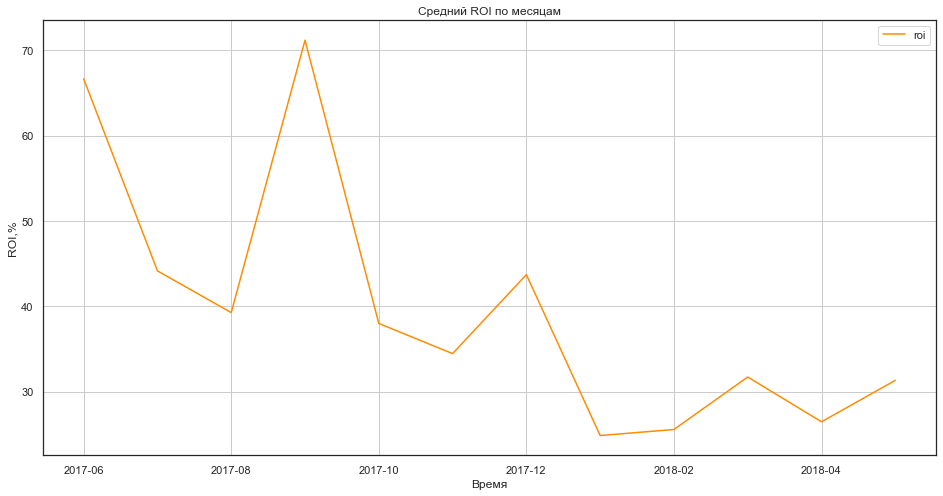

In [136]:
# создаем график
roi_by_month.plot(x='first_buy_month', y='roi', grid=True, color='darkorange')
plt.title('Средний ROI по месяцам')
plt.ylabel('ROI,%')
plt.xlabel('Время')
plt.show()

Видно, что те кто пришёл раньше окупил себя лучше, но это только потому, что у них было больше времени на это. К тому же сдесь показан средний ROI. Опираться на этот график не стоит, лучше провести когортный анализ, к которому мы сейчас и приступим

---

Далее построим кумулятивный ROI по когортам, для начала подготовим таблицу с прибылью по месяцам и когортам:

In [137]:
visits_by_buyers_cohorts = orders_log.groupby(['buy_month','first_buy_month']).agg({'uid':'nunique','revenue':'sum'}).reset_index()

# столбец с возрастом когорт:
visits_by_buyers_cohorts['cohort_month'] = (( visits_by_buyers_cohorts['buy_month'] - visits_by_buyers_cohorts['first_buy_month'] ) / np.timedelta64(1, 'M')).round().astype('int') # месяц/когорта

# сделаем "красивый" месяц, т.е. отбросим день:
visits_by_buyers_cohorts['first_buy_month'] = visits_by_buyers_cohorts['first_buy_month'].dt.strftime('%Y-%m')

# агрегируем данные по когортам (месяцам) и возрастом когорт
visits_by_buyers_cohorts = visits_by_buyers_cohorts.groupby(['first_buy_month','cohort_month']).agg({'uid':'sum','revenue':'sum'}).reset_index()
visits_by_buyers_cohorts

first_buy_month  cohort_month   uid   revenue
0          2017-06             0  2023   9557.49
1          2017-06             1    61    981.82
2          2017-06             2    50    885.34
3          2017-06             3    54   1931.30
4          2017-06             4    88   2068.58
..             ...           ...   ...       ...
74         2018-03             2    58   1114.87
75         2018-04             0  2276  10600.69
76         2018-04             1    69   1209.92
77         2018-05             0  2988  13925.76
78         2018-06             0     1      3.42

[79 rows x 4 columns]

Теперь нужно объеденить с затратами. Помним, что затраты не привязаны к пользователям напрямую, они агрегированы по дням, а для когортного анализа - по мясацам, поэтому мы приписываем все затраты к первому месяцу покупателей (к месяцу когда посетитель совершил первую покупку).

Далее для создания кумулятивного ROI, ` а его нельзя создать с помощью .cumsum(), получатся ошибочные цифры, я проверял`, нужно создать кумулятивных покупателей, т.е. учесть, что они на следующий месяц снова покупали и прибавлять к изначальному числу. И так же кумулятивную прибыль.

`P.S. Поверьте, я всё продумал, так - правильно, даже если другие делают по-другому. Конечно в реальной практике чаще всего есть привязка затрат к User ID, и можно посчитать так же затраты на их повторное привлечение, но конкретно в этом проекте приходится мириться с агрегированными данными`

In [138]:
roi_cohorts = visits_by_buyers_cohorts.merge(costs_by_month, left_on='first_buy_month', right_on='month')

#создаем будущие столбцы с кумулятивными метриками: покупатели и доход
roi_cohorts['cum_buyers'] = 0
roi_cohorts['cum_revenue'] = 0
#наполняем столбцы

for row in roi_cohorts.index: # для каждой строчки (по индексу) таблицы
    
    if roi_cohorts.loc[row, 'cohort_month'] == 0: #если в строке возраст когорты 0, то берем исходное количество (покупателей/дохода)
        
        roi_cohorts.loc[row, 'cum_buyers'] = roi_cohorts.loc[row, 'uid']
        roi_cohorts.loc[row, 'cum_revenue'] = roi_cohorts.loc[row, 'revenue']
    
    else:                                        #иначе прибавляем показатель ячейки покупателей/дохода к сумме предыдущих ячеек
        
        roi_cohorts.loc[row, 'cum_buyers'] = roi_cohorts.loc[row, 'uid'] + roi_cohorts.loc[(row-1), 'cum_buyers']
        roi_cohorts.loc[row, 'cum_revenue'] = roi_cohorts.loc[row, 'revenue'] + roi_cohorts.loc[(row-1), 'cum_revenue']

roi_cohorts

first_buy_month  cohort_month   uid   revenue     costs  cum_buyers  \
0          2017-06             0  2023   9557.49  18015.00        2023   
1          2017-06             1    61    981.82  18015.00        2084   
2          2017-06             2    50    885.34  18015.00        2134   
3          2017-06             3    54   1931.30  18015.00        2188   
4          2017-06             4    88   2068.58  18015.00        2276   
..             ...           ...   ...       ...       ...         ...   
73         2018-03             1    90   1063.05  30415.27        3623   
74         2018-03             2    58   1114.87  30415.27        3681   
75         2018-04             0  2276  10600.69  22289.38        2276   
76         2018-04             1    69   1209.92  22289.38        2345   
77         2018-05             0  2988  13925.76  22224.27        2988   

    cum_revenue  
0       9557.49  
1      10539.31  
2      11424.65  
3      13355.95  
4      15424.53  
..          ...  
73     18158.54  
74     19273.41  
75     10600.69  
76     11810.61  
77     13925.76  

[78 rows x 7 columns]

И теперь можно считать остальные показатели, LTV, CAC, ROI:

In [139]:
roi_cohorts['cum_profit'] = (roi_cohorts['cum_revenue'] * margin_rate).round(2)
roi_cohorts['cum_ltv'] = (roi_cohorts['cum_profit'] / roi_cohorts['cum_buyers']).round(2)
roi_cohorts['cum_cac'] = (roi_cohorts['costs'] / roi_cohorts['cum_buyers']).round(2)
roi_cohorts['cum_roi'] = (roi_cohorts['cum_ltv'] / roi_cohorts['cum_cac']).round(2) # можно ещё посчитать так: (roi['cum_profit']/roi['costs']).round(2) - те же самые цифры
roi_cohorts

first_buy_month  cohort_month   uid   revenue     costs  cum_buyers  \
0          2017-06             0  2023   9557.49  18015.00        2023   
1          2017-06             1    61    981.82  18015.00        2084   
2          2017-06             2    50    885.34  18015.00        2134   
3          2017-06             3    54   1931.30  18015.00        2188   
4          2017-06             4    88   2068.58  18015.00        2276   
..             ...           ...   ...       ...       ...         ...   
73         2018-03             1    90   1063.05  30415.27        3623   
74         2018-03             2    58   1114.87  30415.27        3681   
75         2018-04             0  2276  10600.69  22289.38        2276   
76         2018-04             1    69   1209.92  22289.38        2345   
77         2018-05             0  2988  13925.76  22224.27        2988   

    cum_revenue  cum_profit  cum_ltv  cum_cac  cum_roi  
0       9557.49     4778.74     2.36     8.91     0.26  
1      10539.31     5269.65     2.53     8.64     0.29  
2      11424.65     5712.32     2.68     8.44     0.32  
3      13355.95     6677.97     3.05     8.23     0.37  
4      15424.53     7712.26     3.39     7.92     0.43  
..          ...         ...      ...      ...      ...  
73     18158.54     9079.27     2.51     8.40     0.30  
74     19273.41     9636.70     2.62     8.26     0.32  
75     10600.69     5300.34     2.33     9.79     0.24  
76     11810.61     5905.30     2.52     9.51     0.26  
77     13925.76     6962.88     2.33     7.44     0.31  

[78 rows x 11 columns]

И так как у нас теперь есть уникальные метрики (кумулятивные LTV, CAC и ROI), я выведу их все:

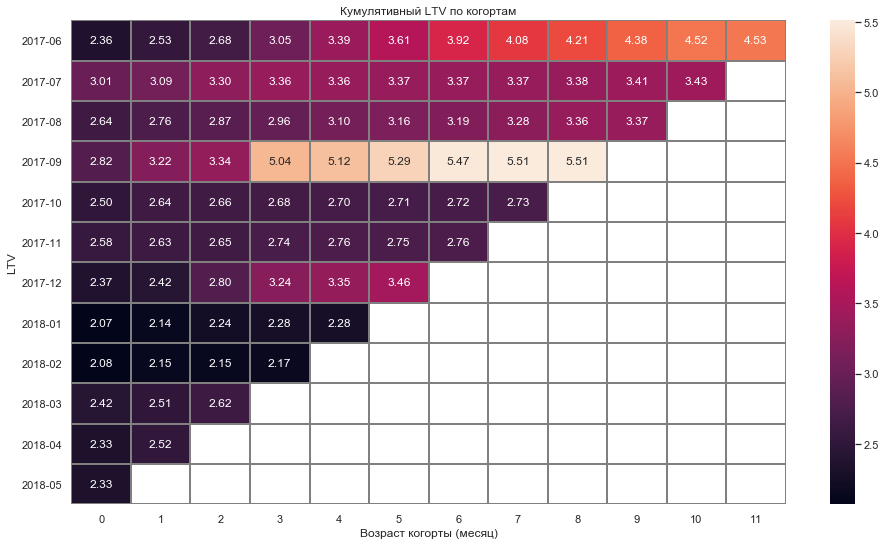

Люди на которых была потрачена сумма на привлечение с течением времени приносят всё больше денег, поэтому средний LTV по когорте растёт


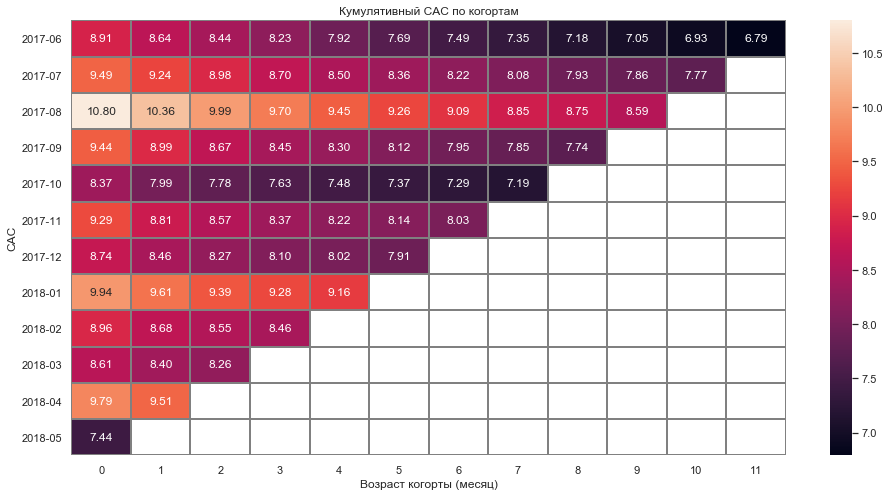

Чем больше люди покупают с течением времени, тем меньше средние затраты на их превлечение, т.е. кумулятивный САС учитывает возврат клиентов


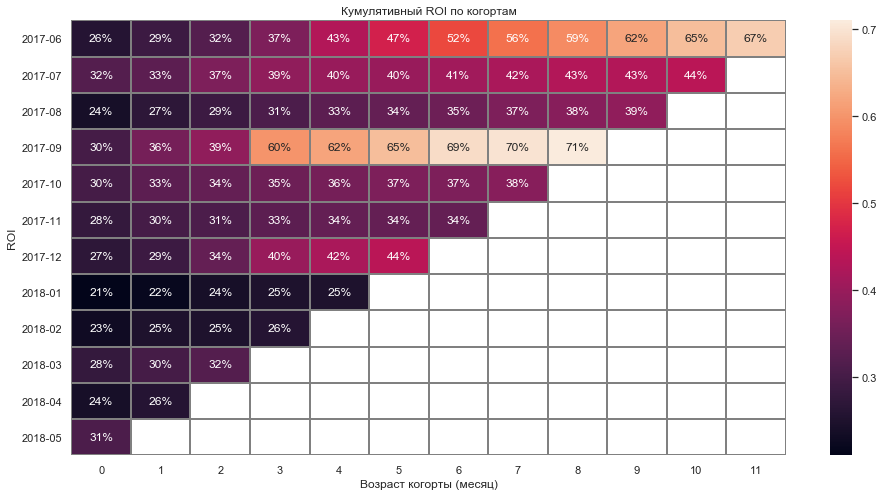

In [140]:
#Когортный анализ кумулятивного LTV

ltv_cohorts_pivot = roi_cohorts.pivot_table(index='first_buy_month', columns='cohort_month', values='cum_ltv').round(2)

plt.figure(figsize=(16, 8.9))
sns.heatmap(ltv_cohorts_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Кумулятивный LTV по когортам')
plt.ylabel('LTV')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

print('Люди на которых была потрачена сумма на привлечение с течением времени приносят всё больше денег, поэтому средний LTV по когорте растёт')

#Когортный анализ кумулятивного CAC

cac_cohorts_pivot = roi_cohorts.pivot_table(index='first_buy_month', columns='cohort_month', values='cum_cac').round(2)

sns.heatmap(cac_cohorts_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Кумулятивный CAC по когортам')
plt.ylabel('CAC')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

print('Чем больше люди покупают с течением времени, тем меньше средние затраты на их превлечение, т.е. кумулятивный САС учитывает возврат клиентов')

#Когортный анализ кумулятивного ROI

roi_cohorts_pivot = roi_cohorts.pivot_table(index='first_buy_month', columns='cohort_month', values='cum_roi').round(2)

sns.heatmap(roi_cohorts_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray')
plt.title('Кумулятивный ROI по когортам')
plt.ylabel('ROI')
plt.xlabel('Возраст когорты (месяц)')
plt.show()

In [141]:
print(f"ROI по всем пользователям за год = {((roi['profit'].sum() / roi['costs'].sum())):.2%}")

ROI по всем пользователям за год = 38.29%


Самая удачная когорта - сентябрьская, она быстро стремится окупить вложения потраченные на них. Но в целом ситуация довольно тяжелая, трафик не окупает себя даже через год. Но возможно риски оправданы в надежде окупить проект через несколько лет. По крайней мере инвесторы кремниевой долины никода не расчитывают получить деньги назад уже через год, там инвестируют по настоящему в долгую. Я думаю здесь примерно такая же история.

Напомню, что маржа установлена как 50%, и этот показатель (если он другой) может кординально поменять картиную.

---

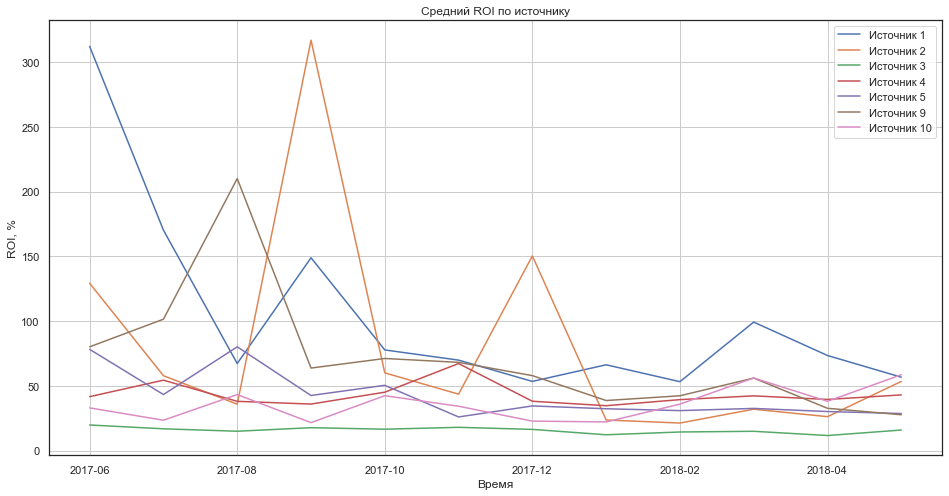

In [142]:
# создаем аггрегированную таблицу затрат по месяцам и источникам
costs_by_month = costs_log.groupby(['month','source_id'])['costs'].sum().reset_index()

# удалим визиты без продаж
visits_by_buyers = visits_and_orders.drop_duplicates(subset=['uid','buy_ts'])

# сгруппируем таблицу и оставим только нужные столбцы с аггрегированными показателями
visits_by_buyers = (visits_by_buyers
                    .groupby(['first_buy_month','source_id'])
                    .agg({'uid':'nunique','revenue':'sum'})
                    .reset_index()
                   )
visits_by_buyers['first_buy_month'] = visits_by_buyers['first_buy_month'].dt.strftime('%Y-%m') #для красоты

# объединяем c затратами
roi_by_source = visits_by_buyers.merge(costs_by_month, left_on=['first_buy_month','source_id'], right_on=['month','source_id'])

# добавляем показатели для подсчёта roi
roi_by_source['profit'] = (roi_by_source['revenue'] * margin_rate).round(2)
roi_by_source['ltv'] = (roi_by_source['profit'] / roi_by_source['uid']).round(2)
roi_by_source['cac'] = (roi_by_source['costs'] / roi_by_source['uid']).round(2)
roi_by_source['roi'] = (roi_by_source['ltv'] / roi_by_source['cac'] *100).round(2) # можно ещё посчитать так: (roi['profit']/roi['costs']).round(2) - те же самые цифры

# сводная таблица по устройствам и месяцам
roi_pivot = (roi_by_source
             .query('(source_id != 6) and (source_id != 7)') # убираем источники с малым количеством данных
             .pivot_table(index='first_buy_month', columns='source_id', values='roi')
            )

# создаем график
roi_pivot.plot(grid=True)
plt.title('Средний ROI по источнику')
plt.legend(['Источник 1','Источник 2','Источник 3','Источник 4','Источник 5','Источник 9','Источник 10'])
plt.ylabel('ROI, %')
plt.xlabel('Время')
plt.show()

Видно, что 3 источник - в самом низу. Это значит, что нужно перераспределить бюджет на 1,2 и 9 источники, которые показывают хорошую окупаемость в течение года. Конечно по 9-му - мало трафика, но это как раз потому, что ту и мало денег было потрачено.

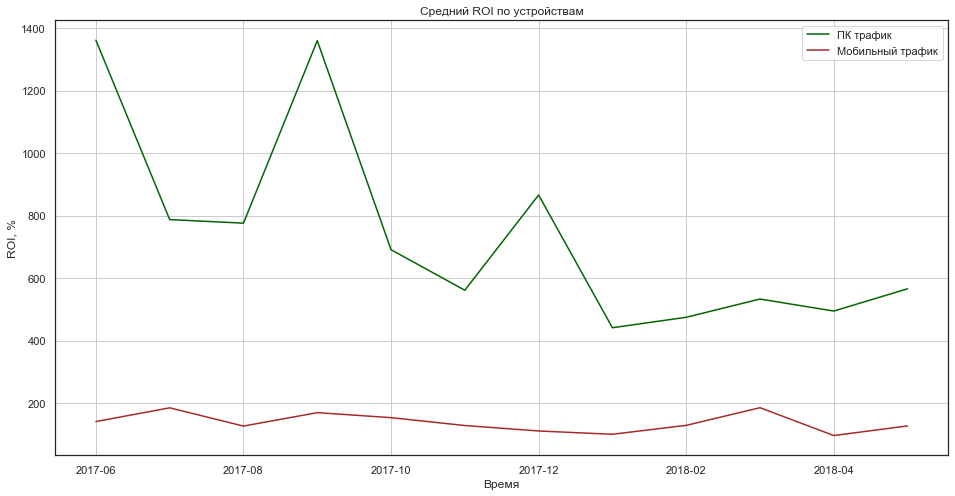

In [143]:
# удалим визиты без продаж
visits_by_buyers = visits_and_orders.drop_duplicates(subset=['uid','buy_ts'])

# сгруппируем таблицу и оставим только нужные столбцы с аггрегированными показателями
visits_by_buyers = (visits_by_buyers
                    .groupby(['first_buy_month','device'])
                    .agg({'uid':'nunique','revenue':'sum'})
                    .reset_index()
                   )
visits_by_buyers['first_buy_month'] = visits_by_buyers['first_buy_month'].dt.strftime('%Y-%m') #для красоты

# объединяем c затратами
roi_by_device = visits_by_buyers.merge(costs_by_month, left_on='first_buy_month', right_on='month')

# добавляем показатели для подсчёта roi
roi_by_device['profit'] = (roi_by_device['revenue'] * margin_rate).round(2)
roi_by_device['ltv'] = (roi_by_device['profit'] / roi_by_device['uid']).round(2)
roi_by_device['cac'] = (roi_by_device['costs'] / roi_by_device['uid']).round(2)
roi_by_device['roi'] = (roi_by_device['ltv'] / roi_by_device['cac'] *100).round(2) # можно ещё посчитать так: (roi['profit']/roi['costs']).round(2) - те же самые цифры

# сводная таблица по устройствам и месяцам
roi_pivot = roi_by_device.pivot_table(index='first_buy_month', columns='device', values='roi') 

# создаем график
roi_pivot.plot(grid=True, color=['darkgreen','brown'])
plt.title('Средний ROI по устройствам')
plt.legend(['ПК трафик','Мобильный трафик'])
plt.ylabel('ROI, %')
plt.xlabel('Время')
plt.show()

Здесь можно увидеть, что в холодные месяцы, когда тратилось больше денег - трафик окупался меньше. Об этом нужно помнить всегда, что увеличение затрат не всегда (или даже почти никогда) не приносит такое же увеличение прибыли.

Что касается устройств, то как мы видим они окупаются почти одинаково, лишь ПК возвращает чуть больше денег, чем мобильный трафик, всё таки стоит сделать корректировку ставок по устройствам.

In [144]:
# удалим визиты без продаж
visits_by_buyers = visits_and_orders.drop_duplicates(subset=['uid','buy_ts'])

#сгруппируем таблицу и оставим только нужные столбцы с аггрегированными показателями
visits_by_buyers = (visits_by_buyers
                    .groupby(['first_buy_month','source_id'])
                    .agg({'uid':'nunique','revenue':'sum'})
                    .reset_index()
                   )
visits_by_buyers['first_buy_month'] = visits_by_buyers['first_buy_month'].dt.strftime('%Y-%m') #для красоты

#объединяем c затратами
roi_by_source = visits_by_buyers.merge(costs_by_month, left_on=['first_buy_month','source_id'], right_on=['month','source_id'])

def funcs(x):
    """
    Функция применяет функции к столбцам,
    создана для правильного посчёта столбца costs,
    в котором нужно сложить только уникальные расходы
    """
    first = x['uid'].sum()
    second =  x['revenue'].sum()
    third = x.groupby('first_buy_month')['costs'].first().sum()
    return pd.Series([first,second,third], index=['uid','revenue','costs'])

#применяем функцию
roi_by_source = roi_by_source.groupby(['source_id']).apply(funcs).reset_index()

#добавляем показатели для подсчёта roi
roi_by_source['profit'] = (roi_by_source['revenue'] * margin_rate).round(2)
roi_by_source['ltv'] = (roi_by_source['profit'] / roi_by_source['uid']).round(2)  
roi_by_source['cac'] = (roi_by_source['costs'] / roi_by_source['uid']).round(2)
roi_by_source['roi'] = (roi_by_source['ltv'] / roi_by_source['cac'] *100).round(2)

roi_by_source

source_id     uid   revenue      costs    profit   ltv    cac    roi
0          1  3743.0  38560.06   20833.27  19280.03  5.15   5.57  92.46
1          2  4323.0  65152.26   42806.04  32576.13  7.54   9.90  76.16
2          3  9138.0  44317.68  141321.63  22158.84  2.42  15.47  15.64
3          4  9822.0  52476.33   61073.60  26238.16  2.67   6.22  42.93
4          5  6839.0  40357.91   51757.10  20178.96  2.95   7.57  38.97
5          9  1415.0   7076.98    5517.49   3538.49  2.50   3.90  64.10
6         10  1241.0   4111.34    5822.49   2055.67  1.66   4.69  35.39

In [145]:
# удалим визиты без продаж
visits_by_buyers = visits_and_orders.drop_duplicates(subset=['uid','buy_ts'])

#сгруппируем таблицу и оставим только нужные столбцы с аггрегированными показателями
visits_by_buyers = (visits_by_buyers
                    .groupby(['first_buy_month','source_id','device'])
                    .agg({'uid':'nunique','revenue':'sum'})
                    .reset_index()
                   )
visits_by_buyers['first_buy_month'] = visits_by_buyers['first_buy_month'].dt.strftime('%Y-%m') #для красоты

#объединяем c затратами
roi_by_source_and_device = visits_by_buyers.merge(costs_by_month, left_on=['first_buy_month','source_id'], right_on=['month','source_id'])

def funcs(x):
    """
    Функция применяет функции к столбцам,
    создана для правильного посчёта столбца costs,
    в котором нужно сложить только уникальные расходы
    """
    first = x['uid'].sum()
    second =  x['revenue'].sum()
    third = x.groupby('first_buy_month')['costs'].first().sum()
    return pd.Series([first,second,third], index=['uid','revenue','costs'])

#применяем функцию
roi_by_source_and_device = roi_by_source_and_device.groupby(['source_id','device']).apply(funcs).reset_index()

#добавляем показатели для подсчёта roi
roi_by_source_and_device['profit'] = (roi_by_source_and_device['revenue'] * margin_rate).round(2)
roi_by_source_and_device['ltv'] = (roi_by_source_and_device['profit'] / roi_by_source_and_device['uid']).round(2)
roi_by_source_and_device['cac'] = (roi_by_source_and_device['costs'] / roi_by_source_and_device['uid']).round(2)
roi_by_source_and_device['roi'] = (roi_by_source_and_device['ltv'] / roi_by_source_and_device['cac'] *100).round(2)

roi_by_source_and_device

source_id   device     uid   revenue      costs    profit   ltv    cac  \
0           1  desktop  2893.0  32394.35   20833.27  16197.18  5.60   7.20   
1           1    touch   850.0   6165.71   20833.27   3082.86  3.63  24.51   
2           2  desktop  3290.0  56679.58   42806.04  28339.79  8.61  13.01   
3           2    touch  1033.0   8472.68   42806.04   4236.34  4.10  41.44   
4           3  desktop  7645.0  37467.44  141321.63  18733.72  2.45  18.49   
5           3    touch  1493.0   6850.24  141321.63   3425.12  2.29  94.66   
6           4  desktop  7595.0  40611.99   61073.60  20306.00  2.67   8.04   
7           4    touch  2227.0  11864.34   61073.60   5932.17  2.66  27.42   
8           5  desktop  5665.0  35067.56   51757.10  17533.78  3.10   9.14   
9           5    touch  1174.0   5290.35   51757.10   2645.18  2.25  44.09   
10          9  desktop  1143.0   5938.57    5517.49   2969.29  2.60   4.83   
11          9    touch   272.0   1138.41    5517.49    569.21  2.09  20.28   
12         10  desktop   989.0   3367.68    5822.49   1683.84  1.70   5.89   
13         10    touch   252.0    743.66    5822.49    371.83  1.48  23.11   

      roi  
0   77.78  
1   14.81  
2   66.18  
3    9.89  
4   13.25  
5    2.42  
6   33.21  
7    9.70  
8   33.92  
9    5.10  
10  53.83  
11  10.31  
12  28.86  
13   6.40

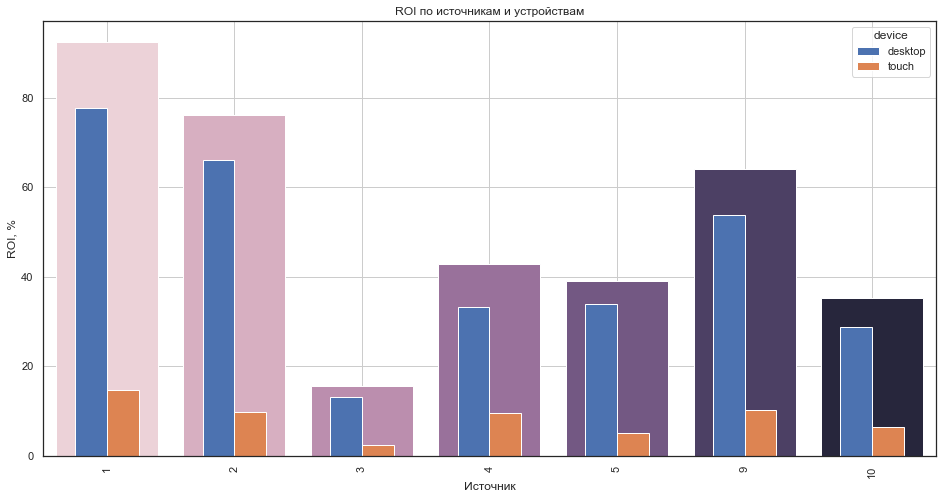

In [146]:
source_df = roi_by_source.query('(source_id != 6) and (source_id != 7)') # убираем источники с малым количеством данных

source_and_device_df = (roi_by_source_and_device
                        .query('(source_id != 6) and (source_id != 7)')
                        .pivot_table(index='source_id', columns='device', values='roi') # сводим по источникам и устройствам 
                       )

# создаем графики
ax = sns.barplot(data=source_df, x='source_id', y='roi',  palette="ch:2.8")
source_and_device_df.plot(grid=True, figsize=(16, 8), kind='bar', ax=ax)
plt.title('ROI по источникам и устройствам')
plt.ylabel('ROI, %')
plt.xlabel('Источник')
plt.show()

Наиболее хорошо окупаются 1,2 и 9 источники. С другой стороны 3 источник окупается очень плохо и почему туда тратят так много денег? Не понятно. Нужно срочно пересматривать бюджет. 

ПК в целом по всем источникам окупается чуть лучше, поэтому на этот трафик нужно тратить больше, чем на мобильный.

---

<h2 align='center'><font color="#513614"> Шаг 3. Вывод </font></h2><br>

Мы рассмотрели множество графиков и показателей, каждый из них по разному отражает состояние бизнеса, но ключевым всегда будет являтся окупается ли деятельность бизнеса и вложения в него или нет. Вывод я буду делать опираясь непосрдственно на ROI.

<b> По источникам </b>

1 - даёт быстро принимающих решение покупателей, с большим количеством покупок и высоким средним чеком. Таким образом трафик окупается быстро, особенно с ПК. Стоит увеличить бюджет и трудозатраты на маркетинг по этому источнику.


2 - почти так же хорош, как и 1 источник, так же можно увеличить бюджет, но уже на 10-15% меньше, чем в 1 источник. И здесь ещё лучше окупается трафик с ПК, поэтому здесь повышающая корректировка должна быть выше (если такая предусмотрена в настройках рекламных кампаний)


3 - самый плохой источник по окупаемости, затраты нужно сократить раз в 10. Конечно, есть шанс, что он приводит трафик, который потом покупает из других источников, для этого нужно проводить отдельное исследование по аттрибуции (т.е. каким был первый источник трафика у тех, кто в итоге купил с другого источника. Но даже если такие покупатели есть, то это лишь несколько процентов от всего трафика с 3 источника. Этот источник привлекает много нецелевого трафика, который даже не возвращается на сайт в последствии.


4 - тоже не очень хороший источник, следует чуть-чуть сократить бюджет на него, но не так сильно как на 3 источник. Единственные преимущества 3 и 4 источника - люди из них достаточно быстро принимают решения о первой покупке, наверно поэтому туда ошибочно вливается много денег.


5 - этот источник можно не трогать в плане бюджета, хоть и окупается он тоже не быстро, у него хороший показатель LTV, и именно этот источник привёл сентябрьскую когорту людей которые в последствии с других источников покупали много и высокими чеками. Нужно больше уделить внимания именно работе с этим источником, сделать его более качественным, оптимизировать


6 и 7 источники я исключал и рассмотрения, т.к. по нима очень мало данных для того, чтобы делать выводы. Но по ним и небыло затрат, может стоит выделить небольшой бюджет для теста. Возможно это хорошие источники для расширения охвата.


9 - источник окупается лучше всех, при этом затраты на него минимальны и соответственно трафика оттуда мало, деньги освободившиеся от 3 источника стоит потратить сюда. Особенно на ПК-пользователей.


10 - окупается нормально, можно попробывать дополнительно финансировать, для теста. Средняя стоимость привлечения на 9 и 10 новых пользователей источниках довольно низкая, люди из этих источников принимают решение о покупке так же бымтро как с 3 и 4. При этом они очень вовлеченные в изучение сайта.


<b> По устройствам </b>


ПК - сайт отвечает потребностям клиентов, всё хорошо, стоит на данный момент тратить больше бюджета на пользователей с ПК, поставить повышающие коэффицентв к ставкам, если речь идёт о контекстной или таргетированной рекламе


Мобильные - стоит доработать сайт с точки зрения UX|UI пока люди значительно больше предпочитают ПК версию, значит, что пока мобильный сайт не отчечает потребностям покупателей, хоть и в целом трафик с мобильных окупается, всё таки на данный момент деньги вложенные на привлечение ПК-пользователей с большей вероятность окупятся


<b> По времении </b>


Нужно больше тратить денег на привлечение летом, т.к. люди в это время окупаются на данный момент лучше, чем зимние. Кстати именно в теплые месяцы 9 и 10 источники окупаются особенно хорошо


Исключение - когорты сентября и декабря - на них стоит обратить внимание, и потратить больше сил на привлечение именно таких пользователей, это 5 источник, это ПК и самое главное - что и менно привлекло этих пользователей, что было на сайте, какая акция проходила. Если этовозможно - нужно составить портрет этой целевой аудитории


На черную пятницу не стоит вливать слишком много денег, как это было сделано, т.к. на распродажу привлекаются охотники за дешевизной, которые в итоге потом не окупаются, ROI когорты ноября очень низкий.